In [1]:
"""
SNR-to-SNR DA using ResNet
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Function

#%% ResNet block
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A basic residual block for 1D convolutions.
        """
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

#%% Base
class DeepResNet(nn.Module):
    """
    A deep ResNet classifier for 1D signals.
    
    This network consists of:
      - An initial convolution + BN + ReLU + maxpool block.
      - Four residual layers (with increasing feature channels).
      - Global average pooling to obtain a fixed–length feature vector.
      - A bottleneck fully connected layer mapping to 512–dimensions.
      - A small classifier head (MLP) mapping to the desired output classes.
    """
    def __init__(self, output_dim=7):
        super(DeepResNet, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer: maps 512-dim to 512-dim features
        self.fc_bottleneck = nn.Linear(512, 512)
        
        # Classifier head (MLP)
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Creates a sequential layer composed of multiple residual blocks.
        If the stride is not 1 or the number of channels change,
        a downsampling layer is used.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, 2, length)
        x = self.conv1(x)    # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (B, 64, L/4)
        
        x = self.layer1(x)   # (B, 64, ?)
        x = self.layer2(x)   # (B, 128, ?)
        x = self.layer3(x)   # (B, 256, ?)
        x = self.layer4(x)   # (B, 512, ?)
        
        x = self.avgpool(x)  # (B, 512, 1)
        x = x.squeeze(-1)    # (B, 512)
        x = self.fc_bottleneck(x)  # (B, 512)
        
        # Classification head
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#%% DANN
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

class DANN_F(nn.Module):
    """
    Deep ResNet feature extractor for DANN.
    
    This network accepts a 2–channel 1D signal and outputs a 512–dimensional feature vector.
    """
    def __init__(self):
        super(DANN_F, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to produce a fixed-length vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer (optional, here keeping feature dim at 512)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Create a sequential layer composed of multiple residual blocks.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x: (batch_size, channels=2, length)
        x = self.conv1(x)    # -> (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # -> (B, 64, L/4)
        
        x = self.layer1(x)   # -> (B, 64, ?)
        x = self.layer2(x)   # -> (B, 128, ?)
        x = self.layer3(x)   # -> (B, 256, ?)
        x = self.layer4(x)   # -> (B, 512, ?)
        
        # Global average pooling
        x = self.avgpool(x)  # -> (B, 512, 1)
        x = x.squeeze(-1)    # -> (B, 512)
        # Bottleneck transformation
        features = self.fc_bottleneck(x)  # (B, 512)
        return features

class DANN_LP(nn.Module):
    """
    Label predictor network that maps 512–dim features to the desired output classes.
    """
    def __init__(self, output_dim=7):
        super(DANN_LP, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class DANN_DC(nn.Module):
    """
    Domain classifier network for DANN.
    
    This network applies a gradient reversal layer (using ReverseLayerF) to the feature vector
    before classifying it as either source or target.
    """
    def __init__(self):
        super(DANN_DC, self).__init__()
        self.fc1 = nn.Linear(512, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x, alpha):
        # Reverse gradient during the backward pass
        x = GradReverse.apply(x, alpha)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#%% CORAL
def coral_loss(source, target):
    """
    Computes the CORAL loss between two matrices.
    Assumes input tensors are of shape (batch_size, feature_dim).
    """
    d = source.size(1)
    ns = source.size(0)
    nt = target.size(0)
    # Center the features
    source_mean = torch.mean(source, dim=0, keepdim=True)
    target_mean = torch.mean(target, dim=0, keepdim=True)
    source_centered = source - source_mean
    target_centered = target - target_mean
    # Compute covariance matrices
    cov_source = (source_centered.t() @ source_centered) / (ns - 1)
    cov_target = (target_centered.t() @ target_centered) / (nt - 1)
    # Frobenius norm between covariance matrices (scaled)
    loss = torch.mean((cov_source - cov_target) ** 2)
    loss = loss / (4 * d * d)
    return loss
        
class CORAL_G(nn.Module):
    """
    Deep ResNet generator that extracts features at multiple depths for CORAL.
    
    Architecture:
      - An initial convolution + batchnorm + ReLU + maxpool.
      - Four layers (residual blocks) built with 1D convolutions.
      - Intermediate features are extracted after layer1 (early), layer2 (middle),
        and layer3 (late) via global average pooling.
      - The final layer (layer4) is pooled and passed through a fully-connected
        bottleneck to obtain a 512–dim feature for classification.
    """
    def __init__(self):
        super(CORAL_G, self).__init__()
        # Initial convolution layer
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling (adaptive to any sequence length)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer mapping 512->512 for classification.
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Creates a sequential layer composed of multiple residual blocks.
        If the stride is not 1 or the channel dimensions differ,
        a downsampling layer is used.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x: (batch_size, channels=2, length)
        x = self.conv1(x)   # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # (B, 64, L/4)
        
        # Layer 1: Early features
        x1 = self.layer1(x)           # (B, 64, L1)
        early = self.avgpool(x1)      # (B, 64, 1)
        early = early.squeeze(-1)     # (B, 64)
        
        # Layer 2: Middle features
        x2 = self.layer2(x1)          # (B, 128, L2)
        middle = self.avgpool(x2)     # (B, 128, 1)
        middle = middle.squeeze(-1)   # (B, 128)
        
        # Layer 3: Late features for CORAL loss
        x3 = self.layer3(x2)          # (B, 256, L3)
        late = self.avgpool(x3)       # (B, 256, 1)
        late = late.squeeze(-1)       # (B, 256)
        
        # Layer 4: Final block for classification
        x4 = self.layer4(x3)          # (B, 512, L4)
        pooled = self.avgpool(x4)     # (B, 512, 1)
        pooled = pooled.squeeze(-1)   # (B, 512)
        final = self.fc_bottleneck(pooled)  # (B, 512)
        
        # Return multi-level features for deep CORAL
        return early, middle, late, final

class CORAL_C(nn.Module):
    """
    Classifier network that maps the 512–dim bottleneck features to the output classes.
    
    Architecture:
      - A fully-connected layer (512 -> 256) with batch normalization, ReLU, and dropout.
      - A final fully-connected layer mapping 256 -> output_dim.
    """
    def __init__(self, output_dim):
        super(CORAL_C, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class DeepCORAL:
    def __init__(self, G, C, device, 
                 S_train_loader, S_val_loader, 
                 T_train_loader, T_val_loader,
                 class_subset, n_classes, lr, n_epochs, n_runs, patience, 
                 lambda_coral=0.5, deep_weights=(1.0, 1.0, 1.0)):
        """
        deep_weights: tuple of weights for the CORAL loss at (early, middle, late) layers.
        """
        self.G = G
        self.C = C
        self.device = device
        self.S_train_loader = S_train_loader
        self.S_val_loader = S_val_loader
        self.T_train_loader = T_train_loader
        self.T_val_loader = T_val_loader
        self.class_subset = class_subset
        self.n_classes = n_classes
        self.lr = lr
        self.n_epochs = n_epochs
        self.n_runs = n_runs
        self.patience = patience
        self.lambda_coral = lambda_coral
        self.deep_weights = deep_weights
        
    def evaluate(self, netG, netC, loader):
        netG.eval()
        netC.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, labels in loader:
                data, labels = data.to(self.device), labels.to(self.device)
                # Only need the classification branch (late_fc)
                _, _, _, cls_feat = netG(data)
                outputs = netC(cls_feat)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    def run(self):
        best_s_acc_list = []
        best_t_acc_list = []
        for run in range(self.n_runs):
            print(f"Deep CORAL Run {run+1}/{self.n_runs}")
            # Instantiate new networks for each run
            netG = self.G().to(self.device)
            netC = self.C(self.n_classes).to(self.device)
            optimizer = torch.optim.Adam(list(netG.parameters()) + list(netC.parameters()), lr=self.lr)
            criterion = nn.CrossEntropyLoss()
            best_val_acc = 0.0
            patience_counter = 0
            
            for epoch in range(self.n_epochs):
                netG.train()
                netC.train()
                # Use zip to iterate over source and target batches in parallel.
                for (s_data, s_labels), (t_data, _) in zip(self.S_train_loader, self.T_train_loader):
                    s_data, s_labels = s_data.to(self.device), s_labels.to(self.device)
                    t_data = t_data.to(self.device)
                    
                    # Forward pass for source: get all features
                    s_early, s_middle, s_late, s_cls = netG(s_data)
                    # Classification loss on source (using the classification feature)
                    loss_cls = criterion(netC(s_cls), s_labels)
                    
                    # Forward pass for target: we only need the intermediate features
                    t_early, t_middle, t_late, _ = netG(t_data)
                    
                    # Compute CORAL loss for each level
                    loss_early = coral_loss(s_early, t_early)
                    loss_middle = coral_loss(s_middle, t_middle)
                    loss_late = coral_loss(s_late, t_late)
                    loss_coral_total = (self.deep_weights[0] * loss_early +
                                        self.deep_weights[1] * loss_middle +
                                        self.deep_weights[2] * loss_late)
                    
                    total_loss = loss_cls + self.lambda_coral * loss_coral_total
                    
                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()
                    
                # End-of-epoch evaluation on source validation set
                s_acc = self.evaluate(netG, netC, self.S_val_loader)
                t_acc = self.evaluate(netG, netC, self.T_val_loader)
                print(f"Epoch {epoch+1}: Source Val Acc = {s_acc:.4f}, Target Val Acc = {t_acc:.4f}")
                
                # Early stopping on source validation accuracy
                if s_acc > best_val_acc:
                    best_val_acc = s_acc
                    best_model_G = netG.state_dict()
                    best_model_C = netC.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= self.patience:
                    print("Early stopping triggered.")
                    break
                    
            # Load best model from this run
            netG.load_state_dict(best_model_G)
            netC.load_state_dict(best_model_C)
            s_acc = self.evaluate(netG, netC, self.S_val_loader)
            t_acc = self.evaluate(netG, netC, self.T_val_loader)
            print(f"Run {run+1} finished: Best Source Val Acc = {s_acc:.4f}, Target Val Acc = {t_acc:.4f}\n")
            best_s_acc_list.append(s_acc)
            best_t_acc_list.append(t_acc)
            
        avg_s_acc = np.mean(best_s_acc_list)
        avg_t_acc = np.mean(best_t_acc_list)
        print(f"Deep CORAL: Average Source Val Acc = {avg_s_acc:.4f}, Average Target Val Acc = {avg_t_acc:.4f}")
        return avg_s_acc, avg_t_acc

#%% STAR
class STAR_G(nn.Module):
    """
    Deep ResNet feature extractor for STAR.
    
    This network accepts a 2–channel 1D signal and extracts a 512–dimensional
    feature vector via several residual layers.
    """
    def __init__(self):
        super(STAR_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Optional bottleneck fully-connected layer (maps 512->512)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, channels=2, length)
        x = self.conv1(x)      # (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # (B, 64, L/4)
        
        x = self.layer1(x)     # (B, 64, ?)
        x = self.layer2(x)     # (B, 128, ?)
        x = self.layer3(x)     # (B, 256, ?)
        x = self.layer4(x)     # (B, 512, ?)
        
        x = self.avgpool(x)    # (B, 512, 1)
        x = x.squeeze(-1)      # (B, 512)
        x = self.fc_bottleneck(x)  # (B, 512)
        return x

class STAR_C(nn.Module):
    """
    Stochastic classifier network for STAR.
    
    This network receives the 512–dim features from DeepResNet_STAR_G,
    applies a fully connected layer with batch normalization and ReLU,
    and then uses a learned weight distribution (mu2, sigma2) to sample
    classifier weights. During training, it samples num_classifiers_train classifiers,
    while during evaluation it can either use only the mean (only_mu=True) or
    sample num_classifiers_test classifiers.
    """
    def __init__(self, output_dim, num_classifiers_train=2, num_classifiers_test=20,
                 init='kaiming_u', use_init=False):
        super(STAR_C, self).__init__()
        self.num_classifiers_train = num_classifiers_train
        self.num_classifiers_test = num_classifiers_test
        self.init = init

        function_init = {
            'kaiming_u': nn.init.kaiming_uniform_,
            'kaiming_n': nn.init.kaiming_normal_,
            'xavier': nn.init.xavier_normal_
        }

        # Change input dimension to 512 (from the DeepResNet feature extractor)
        self.fc1 = nn.Linear(512, 128)
        self.bn1_fc = nn.BatchNorm1d(128)

        # Learnable parameters for the classifier weight distribution
        self.mu2 = nn.Parameter(torch.randn(output_dim, 128))
        self.sigma2 = nn.Parameter(torch.zeros(output_dim, 128))

        if use_init:
            for item in [self.mu2, self.sigma2]:
                function_init[self.init](item)

        self.b2 = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, only_mu=True):
        x = self.fc1(x)
        x = F.relu(self.bn1_fc(x))

        sigma2_pos = torch.sigmoid(self.sigma2)
        fc2_distribution = torch.distributions.Normal(self.mu2, sigma2_pos)

        if self.training:
            classifiers = []
            for _ in range(self.num_classifiers_train):
                fc2_w = fc2_distribution.rsample()
                classifiers.append([fc2_w, self.b2])

            outputs = []
            for classifier in classifiers:
                out = F.linear(x, classifier[0], classifier[1])
                outputs.append(out)
            return outputs
        else:
            if only_mu:
                out = F.linear(x, self.mu2, self.b2)
                return [out]
            else:
                classifiers = []
                for _ in range(self.num_classifiers_test):
                    fc2_w = fc2_distribution.rsample()
                    classifiers.append([fc2_w, self.b2])
                outputs = []
                for classifier in classifiers:
                    out = F.linear(x, classifier[0], classifier[1])
                    outputs.append(out)
                return outputs

#%% MCD
class MCD_G(nn.Module):
    def __init__(self):
        super(MCD_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(in_channels=64, out_channels=64, blocks=2, stride=1)
        self.layer2 = self._make_layer(in_channels=64, out_channels=128, blocks=2, stride=2)
        self.layer3 = self._make_layer(in_channels=128, out_channels=256, blocks=2, stride=2)
        self.layer4 = self._make_layer(in_channels=256, out_channels=512, blocks=2, stride=2)
        
        # Global average pooling to get a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck fully-connected layer mapping 512 -> 512 (optional)
        self.fc_bottleneck = nn.Linear(512, 512)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Input x shape: (batch_size, 2, length)
        x = self.conv1(x)      # -> (B, 64, L/2)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # -> (B, 64, L/4)
        
        x = self.layer1(x)     # -> (B, 64, ?)
        x = self.layer2(x)     # -> (B, 128, ?)
        x = self.layer3(x)     # -> (B, 256, ?)
        x = self.layer4(x)     # -> (B, 512, ?)
        
        x = self.avgpool(x)    # -> (B, 512, 1)
        x = x.squeeze(-1)      # -> (B, 512)
        x = self.fc_bottleneck(x)  # -> (B, 512)
        return x

class MCD_C(nn.Module):
    def __init__(self, output_dim):
        super(MCD_C, self).__init__()
        # Since our feature extractor now outputs a 512-dim vector,
        # adjust the input dimension accordingly.
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x, reverse=False, lambda_=1.0):
        # Optionally apply gradient reversal
        if reverse:
            x = grad_reverse(x, lambda_)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#%% JAN
class JAN_G(nn.Module):
    def __init__(self):
        super(JAN_G, self).__init__()
        # Initial convolutional block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        
        # Global average pooling to obtain a fixed-length feature vector
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # Bottleneck layer mapping 512 -> 512 dimensions
        self.fc_bottleneck = nn.Linear(512, 512)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch_size, 2, length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)  # shape: (batch, 512, 1)
        x = x.squeeze(-1)    # shape: (batch, 512)
        x = self.fc_bottleneck(x)  # shape: (batch, 512)
        
        # Debug: Ensure x is a valid tensor
        if x is None:
            raise ValueError("Generator output is None. Check your forward pass.")
        # You can also uncomment the next line to print the shape during debugging.
        # print("Generator output shape:", x.shape)
        return x

class C_JAN(nn.Module):
    def __init__(self, output_dim):
        super(C_JAN, self).__init__()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, output_dim)
        
    def forward(self, x, return_intermediate=False):
        inter = torch.relu(self.fc1(x))
        out = self.fc2(inter)
        if return_intermediate:
            return out, inter
        else:
            return out

In [2]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/ota_X.npy")
Y = np.load(file_path + "/ota_Y.npy")

sou_snr = 30
tar_snr = 10

t_deep_coral_acc = []
t_base_acc = []
t_dann_acc = []
t_mcd_acc = []
t_star_acc = []
t_jan_acc = []

n_runs = 10
n_epochs= 50
lr = 0.001
n_snr= 6

for i in range(n_snr):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('Base')
    _, t_base = base.Base(
        model_cls=DeepResNet,
        device=device,
        S_train_loader=S_train_loader, 
        S_val_loader=S_val_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset, 
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_base_acc.append(t_base)

    print('DANN')
    _, t_dann = dann.DAN(
        dann.DANN,
        FA=DANN_F,
        LP=DANN_LP,
        DC=DANN_DC,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_dann_acc.append(t_dann)

    print('Deep CORAL')
    _, t_deep = DeepCORAL(
        G=CORAL_G, 
        C=CORAL_C, 
        device=device, 
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr, 
        n_epochs=n_epochs, 
        n_runs=n_runs,
        patience=5,
        lambda_coral=0.5,
        deep_weights=(1.0, 1.0, 1.0)
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    print('STAR')
    _, t_star =  star.Star(
        G=STAR_G,
        C=STAR_C,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,  
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs,
        patience=5
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_star_acc.append(t_star)

    print('MCD')
    _, t_mcd = mcd.Mcd(
        G=MCD_G,
        C=MCD_C,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,  
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs,
        patience=5
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_mcd_acc.append(t_mcd)

    print('JAN')
    _, t_jan = jan.Jan(
        C=C_JAN,
        G=JAN_G,
        num_classes=len(class_subset),
        device=device,
        S_train_loader=S_train_loader,
        T_train_loader=T_train_loader,
        S_val_loader=S_val_loader,
        T_val_loader=T_val_loader,
        n_epochs=n_epochs,
        lr=lr,
        lambda_jmmd=0.1,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_jan_acc.append(t_jan)
    
    tar_snr += 4

Base

Run 1/10
Epoch 1/50, Train Loss: 0.3395, Train Acc: 0.8854, Val Loss: 1.8362, Val Acc: 0.5965
Epoch 2/50, Train Loss: 0.0395, Train Acc: 0.9904, Val Loss: 0.0448, Val Acc: 0.9862
Epoch 3/50, Train Loss: 0.0263, Train Acc: 0.9942, Val Loss: 0.1226, Val Acc: 0.9484
Epoch 4/50, Train Loss: 0.0205, Train Acc: 0.9922, Val Loss: 0.0494, Val Acc: 0.9856
Epoch 5/50, Train Loss: 0.0347, Train Acc: 0.9906, Val Loss: 0.0606, Val Acc: 0.9784
Epoch 6/50, Train Loss: 0.0075, Train Acc: 0.9990, Val Loss: 0.2259, Val Acc: 0.9227
Epoch 7/50, Train Loss: 0.0117, Train Acc: 0.9969, Val Loss: 0.0248, Val Acc: 0.9922
Epoch 8/50, Train Loss: 0.0070, Train Acc: 0.9990, Val Loss: 0.0026, Val Acc: 0.9994
Epoch 9/50, Train Loss: 0.0044, Train Acc: 0.9988, Val Loss: 0.0041, Val Acc: 0.9994
Epoch 10/50, Train Loss: 0.0059, Train Acc: 0.9990, Val Loss: 0.0506, Val Acc: 0.9820
Epoch 11/50, Train Loss: 0.0016, Train Acc: 0.9999, Val Loss: 0.0005, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0027, Train Acc: 0.99

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3201, Train Acc: 0.8974, Val Loss: 2.3417, Val Acc: 0.3579
Epoch 2/50, Train Loss: 0.0375, Train Acc: 0.9907, Val Loss: 0.1508, Val Acc: 0.9478
Epoch 3/50, Train Loss: 0.0236, Train Acc: 0.9933, Val Loss: 0.3762, Val Acc: 0.8201
Epoch 4/50, Train Loss: 0.0294, Train Acc: 0.9921, Val Loss: 0.4092, Val Acc: 0.8807
Epoch 5/50, Train Loss: 0.0134, Train Acc: 0.9964, Val Loss: 0.0519, Val Acc: 0.9784
Epoch 6/50, Train Loss: 0.0170, Train Acc: 0.9957, Val Loss: 0.0157, Val Acc: 0.9970
Epoch 7/50, Train Loss: 0.0146, Train Acc: 0.9954, Val Loss: 0.0190, Val Acc: 0.9946
Epoch 8/50, Train Loss: 0.0225, Train Acc: 0.9940, Val Loss: 0.1335, Val Acc: 0.9526
Epoch 9/50, Train Loss: 0.0173, Train Acc: 0.9948, Val Loss: 0.0597, Val Acc: 0.9796
Epoch 10/50, Train Loss: 0.0049, Train Acc: 0.9987, Val Loss: 0.0177, Val Acc: 0.9934
Epoch 11/50, Train Loss: 0.0035, Train Acc: 0.9991, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0024, Train Acc: 0.9994, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3641, Train Acc: 0.8808, Val Loss: 1.6527, Val Acc: 0.6151
Epoch 2/50, Train Loss: 0.0583, Train Acc: 0.9850, Val Loss: 0.0107, Val Acc: 0.9970
Epoch 3/50, Train Loss: 0.0222, Train Acc: 0.9942, Val Loss: 0.0152, Val Acc: 0.9976
Epoch 4/50, Train Loss: 0.0213, Train Acc: 0.9927, Val Loss: 0.0302, Val Acc: 0.9964
Epoch 5/50, Train Loss: 0.0158, Train Acc: 0.9958, Val Loss: 0.2764, Val Acc: 0.8579
Epoch 6/50, Train Loss: 0.0096, Train Acc: 0.9976, Val Loss: 0.0129, Val Acc: 0.9952
Epoch 7/50, Train Loss: 0.0079, Train Acc: 0.9988, Val Loss: 0.2020, Val Acc: 0.9376
Early stopping!

Run 4/10


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3465, Train Acc: 0.8881, Val Loss: 1.3210, Val Acc: 0.5252
Epoch 2/50, Train Loss: 0.0430, Train Acc: 0.9877, Val Loss: 0.3832, Val Acc: 0.8771
Epoch 3/50, Train Loss: 0.0330, Train Acc: 0.9903, Val Loss: 0.0487, Val Acc: 0.9820
Epoch 4/50, Train Loss: 0.0283, Train Acc: 0.9916, Val Loss: 0.5089, Val Acc: 0.8429
Epoch 5/50, Train Loss: 0.0308, Train Acc: 0.9913, Val Loss: 0.0071, Val Acc: 0.9970
Epoch 6/50, Train Loss: 0.0179, Train Acc: 0.9963, Val Loss: 0.2267, Val Acc: 0.9275
Epoch 7/50, Train Loss: 0.0167, Train Acc: 0.9946, Val Loss: 0.0145, Val Acc: 0.9958
Epoch 8/50, Train Loss: 0.0240, Train Acc: 0.9951, Val Loss: 0.0461, Val Acc: 0.9880
Epoch 9/50, Train Loss: 0.0029, Train Acc: 0.9996, Val Loss: 0.0010, Val Acc: 1.0000
Epoch 10/50, Train Loss: 0.0055, Train Acc: 0.9979, Val Loss: 0.0137, Val Acc: 0.9958
Epoch 11/50, Train Loss: 0.0045, Train Acc: 0.9988, Val Loss: 0.0005, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0017, Train Acc: 0.9996, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3724, Train Acc: 0.8757, Val Loss: 0.5505, Val Acc: 0.8064
Epoch 2/50, Train Loss: 0.0533, Train Acc: 0.9862, Val Loss: 0.8340, Val Acc: 0.7860
Epoch 3/50, Train Loss: 0.0385, Train Acc: 0.9895, Val Loss: 0.1587, Val Acc: 0.9466
Epoch 4/50, Train Loss: 0.0320, Train Acc: 0.9913, Val Loss: 1.1393, Val Acc: 0.7590
Epoch 5/50, Train Loss: 0.0216, Train Acc: 0.9943, Val Loss: 0.6166, Val Acc: 0.8471
Epoch 6/50, Train Loss: 0.0173, Train Acc: 0.9946, Val Loss: 0.0693, Val Acc: 0.9772
Epoch 7/50, Train Loss: 0.0063, Train Acc: 0.9984, Val Loss: 0.0125, Val Acc: 0.9946
Epoch 8/50, Train Loss: 0.0059, Train Acc: 0.9981, Val Loss: 0.6356, Val Acc: 0.7878
Epoch 9/50, Train Loss: 0.0202, Train Acc: 0.9937, Val Loss: 1.7151, Val Acc: 0.7464
Epoch 10/50, Train Loss: 0.0109, Train Acc: 0.9972, Val Loss: 0.0177, Val Acc: 0.9970
Epoch 11/50, Train Loss: 0.0044, Train Acc: 0.9994, Val Loss: 0.0047, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0036, Train Acc: 0.9991, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3527, Train Acc: 0.8850, Val Loss: 0.8774, Val Acc: 0.7278
Epoch 2/50, Train Loss: 0.0407, Train Acc: 0.9912, Val Loss: 0.1475, Val Acc: 0.9502
Epoch 3/50, Train Loss: 0.0263, Train Acc: 0.9924, Val Loss: 0.0129, Val Acc: 0.9970
Epoch 4/50, Train Loss: 0.0110, Train Acc: 0.9970, Val Loss: 0.3553, Val Acc: 0.8933
Epoch 5/50, Train Loss: 0.0239, Train Acc: 0.9937, Val Loss: 0.1890, Val Acc: 0.9850
Epoch 6/50, Train Loss: 0.0214, Train Acc: 0.9933, Val Loss: 0.4364, Val Acc: 0.8741
Epoch 7/50, Train Loss: 0.0118, Train Acc: 0.9976, Val Loss: 1.6708, Val Acc: 0.7644
Epoch 8/50, Train Loss: 0.0063, Train Acc: 0.9988, Val Loss: 0.0124, Val Acc: 0.9964
Epoch 9/50, Train Loss: 0.0111, Train Acc: 0.9969, Val Loss: 0.1478, Val Acc: 0.9347
Epoch 10/50, Train Loss: 0.0127, Train Acc: 0.9967, Val Loss: 0.2897, Val Acc: 0.8345
Epoch 11/50, Train Loss: 0.0040, Train Acc: 0.9993, Val Loss: 0.0009, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0025, Train Acc: 0.9994, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.2700, Train Acc: 0.9160, Val Loss: 1.5308, Val Acc: 0.5977
Epoch 2/50, Train Loss: 0.0376, Train Acc: 0.9892, Val Loss: 0.0158, Val Acc: 0.9958
Epoch 3/50, Train Loss: 0.0435, Train Acc: 0.9873, Val Loss: 0.2321, Val Acc: 0.9329
Epoch 4/50, Train Loss: 0.0345, Train Acc: 0.9888, Val Loss: 2.1367, Val Acc: 0.7398
Epoch 5/50, Train Loss: 0.0223, Train Acc: 0.9936, Val Loss: 0.0102, Val Acc: 0.9976
Epoch 6/50, Train Loss: 0.0064, Train Acc: 0.9987, Val Loss: 0.0028, Val Acc: 0.9988
Epoch 7/50, Train Loss: 0.0183, Train Acc: 0.9948, Val Loss: 0.2566, Val Acc: 0.9167
Epoch 8/50, Train Loss: 0.0088, Train Acc: 0.9973, Val Loss: 0.0430, Val Acc: 0.9958
Epoch 9/50, Train Loss: 0.0096, Train Acc: 0.9975, Val Loss: 0.0074, Val Acc: 0.9976
Epoch 10/50, Train Loss: 0.0055, Train Acc: 0.9987, Val Loss: 0.0008, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0028, Train Acc: 0.9994, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0034, Train Acc: 0.9991, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3217, Train Acc: 0.8959, Val Loss: 0.1079, Val Acc: 0.9724
Epoch 2/50, Train Loss: 0.0409, Train Acc: 0.9877, Val Loss: 0.2260, Val Acc: 0.9239
Epoch 3/50, Train Loss: 0.0173, Train Acc: 0.9954, Val Loss: 0.0310, Val Acc: 0.9934
Epoch 4/50, Train Loss: 0.0240, Train Acc: 0.9939, Val Loss: 0.0857, Val Acc: 0.9694
Epoch 5/50, Train Loss: 0.0276, Train Acc: 0.9915, Val Loss: 0.2008, Val Acc: 0.9299
Epoch 6/50, Train Loss: 0.0150, Train Acc: 0.9952, Val Loss: 1.1862, Val Acc: 0.7626
Epoch 7/50, Train Loss: 0.0057, Train Acc: 0.9985, Val Loss: 0.0021, Val Acc: 1.0000
Epoch 8/50, Train Loss: 0.0078, Train Acc: 0.9978, Val Loss: 2.7111, Val Acc: 0.7422
Epoch 9/50, Train Loss: 0.0079, Train Acc: 0.9975, Val Loss: 3.2816, Val Acc: 0.5138
Epoch 10/50, Train Loss: 0.0075, Train Acc: 0.9985, Val Loss: 0.0168, Val Acc: 0.9940
Epoch 11/50, Train Loss: 0.0039, Train Acc: 0.9991, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0084, Train Acc: 0.9982, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3557, Train Acc: 0.8766, Val Loss: 2.5657, Val Acc: 0.4083
Epoch 2/50, Train Loss: 0.0530, Train Acc: 0.9858, Val Loss: 0.2217, Val Acc: 0.9119
Epoch 3/50, Train Loss: 0.0279, Train Acc: 0.9919, Val Loss: 0.4616, Val Acc: 0.8573
Epoch 4/50, Train Loss: 0.0333, Train Acc: 0.9894, Val Loss: 0.0231, Val Acc: 0.9916
Epoch 5/50, Train Loss: 0.0114, Train Acc: 0.9981, Val Loss: 0.0150, Val Acc: 0.9958
Epoch 6/50, Train Loss: 0.0090, Train Acc: 0.9979, Val Loss: 1.6204, Val Acc: 0.7530
Epoch 7/50, Train Loss: 0.0220, Train Acc: 0.9933, Val Loss: 0.3182, Val Acc: 0.8939
Epoch 8/50, Train Loss: 0.0146, Train Acc: 0.9958, Val Loss: 0.0180, Val Acc: 0.9970
Epoch 9/50, Train Loss: 0.0067, Train Acc: 0.9979, Val Loss: 0.6799, Val Acc: 0.8118
Epoch 10/50, Train Loss: 0.0153, Train Acc: 0.9961, Val Loss: 2.1845, Val Acc: 0.6847
Early stopping!

Run 10/10


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3396, Train Acc: 0.8865, Val Loss: 2.7183, Val Acc: 0.5288
Epoch 2/50, Train Loss: 0.0400, Train Acc: 0.9894, Val Loss: 0.2548, Val Acc: 0.9053
Epoch 3/50, Train Loss: 0.0301, Train Acc: 0.9913, Val Loss: 0.1137, Val Acc: 0.9568
Epoch 4/50, Train Loss: 0.0145, Train Acc: 0.9967, Val Loss: 0.0047, Val Acc: 0.9976
Epoch 5/50, Train Loss: 0.0083, Train Acc: 0.9972, Val Loss: 0.4841, Val Acc: 0.8597
Epoch 6/50, Train Loss: 0.0134, Train Acc: 0.9952, Val Loss: 0.0162, Val Acc: 0.9952
Epoch 7/50, Train Loss: 0.0109, Train Acc: 0.9967, Val Loss: 0.0499, Val Acc: 0.9844
Epoch 8/50, Train Loss: 0.0132, Train Acc: 0.9964, Val Loss: 0.0040, Val Acc: 0.9988
Epoch 9/50, Train Loss: 0.0046, Train Acc: 0.9988, Val Loss: 0.0610, Val Acc: 0.9850
Epoch 10/50, Train Loss: 0.0101, Train Acc: 0.9973, Val Loss: 0.0881, Val Acc: 0.9742
Epoch 11/50, Train Loss: 0.0035, Train Acc: 0.9993, Val Loss: 0.0014, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0017, Train Acc: 0.9997, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2974, Domain Loss: 1.3296, Class Loss: 0.9678
Epoch 2/50, Loss: 1.5972, Domain Loss: 1.1383, Class Loss: 0.4590
Epoch 3/50, Loss: 1.6169, Domain Loss: 1.4289, Class Loss: 0.1881
Epoch 4/50, Loss: 6.3190, Domain Loss: 5.9362, Class Loss: 0.3828
Epoch 5/50, Loss: 9.2052, Domain Loss: 8.9078, Class Loss: 0.2974
Epoch 6/50, Loss: 8.4529, Domain Loss: 8.1916, Class Loss: 0.2613
Epoch 7/50, Loss: 5.2344, Domain Loss: 4.9685, Class Loss: 0.2659
Epoch 8/50, Loss: 5.9163, Domain Loss: 5.5460, Class Loss: 0.3703
Epoch 9/50, Loss: 7.7857, Domain Loss: 7.4581, Class Loss: 0.3276
Epoch 10/50, Loss: 4.9765, Domain Loss: 4.5067, Class Loss: 0.4697
Epoch 11/50, Loss: 5.3837, Domain Loss: 4.8990, Class Loss: 0.4847
Epoch 12/50, Loss: 3.6134, Domain Loss: 3.2825, Class Loss: 0.3309
Epoch 13/50, Loss: 3.1579, Domain Loss: 2.6525, Class Loss: 0.5054
Epoch 14/50, Loss: 3.0276, Domain Loss: 2.6118, Class Loss: 0.4158
Epoch 15/50, Loss: 4.0512, Domain Loss: 3.4952, Class Loss: 0.5560
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2962, Domain Loss: 1.3277, Class Loss: 0.9685
Epoch 2/50, Loss: 1.5394, Domain Loss: 1.2737, Class Loss: 0.2657
Epoch 3/50, Loss: 2.4755, Domain Loss: 2.2582, Class Loss: 0.2173
Epoch 4/50, Loss: 3.7437, Domain Loss: 3.5833, Class Loss: 0.1604
Epoch 5/50, Loss: 6.2104, Domain Loss: 5.9781, Class Loss: 0.2323
Epoch 6/50, Loss: 3.8307, Domain Loss: 3.5565, Class Loss: 0.2742
Epoch 7/50, Loss: 4.2934, Domain Loss: 3.9968, Class Loss: 0.2966
Epoch 8/50, Loss: 3.9219, Domain Loss: 3.6097, Class Loss: 0.3121
Epoch 9/50, Loss: 4.6265, Domain Loss: 4.2917, Class Loss: 0.3348
Epoch 10/50, Loss: 3.0692, Domain Loss: 2.6471, Class Loss: 0.4222
Epoch 11/50, Loss: 3.0218, Domain Loss: 2.5131, Class Loss: 0.5087
Epoch 12/50, Loss: 2.0524, Domain Loss: 1.7988, Class Loss: 0.2535
Epoch 13/50, Loss: 2.2847, Domain Loss: 2.1126, Class Loss: 0.1721
Epoch 14/50, Loss: 3.3949, Domain Loss: 3.2377, Class Loss: 0.1572
Epoch 15/50, Loss: 3.7218, Domain Loss: 3.4287, Class Loss: 0.2930
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.3093, Domain Loss: 1.3395, Class Loss: 0.9698
Epoch 2/50, Loss: 1.6312, Domain Loss: 1.2102, Class Loss: 0.4210
Epoch 3/50, Loss: 2.3609, Domain Loss: 2.1094, Class Loss: 0.2515
Epoch 4/50, Loss: 6.3950, Domain Loss: 6.1570, Class Loss: 0.2380
Epoch 5/50, Loss: 12.0731, Domain Loss: 11.8650, Class Loss: 0.2081
Epoch 6/50, Loss: 10.7351, Domain Loss: 10.4927, Class Loss: 0.2425
Epoch 7/50, Loss: 7.7889, Domain Loss: 7.5526, Class Loss: 0.2363
Epoch 8/50, Loss: 3.3754, Domain Loss: 3.2000, Class Loss: 0.1755
Epoch 9/50, Loss: 2.1420, Domain Loss: 2.0006, Class Loss: 0.1414
Epoch 10/50, Loss: 1.6464, Domain Loss: 1.5364, Class Loss: 0.1100
Epoch 11/50, Loss: 2.2151, Domain Loss: 1.9817, Class Loss: 0.2334
Epoch 12/50, Loss: 2.1797, Domain Loss: 2.0383, Class Loss: 0.1414
Epoch 13/50, Loss: 2.1194, Domain Loss: 1.8781, Class Loss: 0.2413
Epoch 14/50, Loss: 2.2320, Domain Loss: 1.8204, Class Loss: 0.4116
Epoch 15/50, Loss: 1.6904, Domain Loss: 1.4524, Class Loss: 0.2381


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Source Val Acc = 0.5024, Target Val Acc = 0.5150
Epoch 2: Source Val Acc = 0.4952, Target Val Acc = 0.4850
Epoch 3: Source Val Acc = 0.5096, Target Val Acc = 0.4982
Epoch 4: Source Val Acc = 0.4934, Target Val Acc = 0.5234
Epoch 5: Source Val Acc = 0.5024, Target Val Acc = 0.5641
Epoch 6: Source Val Acc = 0.9574, Target Val Acc = 0.5456
Epoch 7: Source Val Acc = 0.5498, Target Val Acc = 0.6289
Epoch 8: Source Val Acc = 0.5084, Target Val Acc = 0.6091
Epoch 9: Source Val Acc = 0.6325, Target Val Acc = 0.5348
Epoch 10: Source Val Acc = 0.5030, Target Val Acc = 0.5558
Epoch 11: Source Val Acc = 0.8417, Target Val Acc = 0.5486
Early stopping triggered.
Run 1 finished: Best Source Val Acc = 0.8417, Target Val Acc = 0.5486

Deep CORAL Run 2/10
Epoch 1: Source Val Acc = 0.5222, Target Val Acc = 0.5618
Epoch 2: Source Val Acc = 0.2614, Target Val Acc = 0.2536
Epoch 3: Source Val Acc = 0.5096, Target Val Acc = 0.4880
Epoch 4: Source Val Acc = 0.5306, Target Val Acc = 0.4904
Epoch 5: So

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3367, Train Acc: 0.8899, Val Loss: 1.2048, Val Acc: 0.7104
Epoch 2/50, Train Loss: 0.0400, Train Acc: 0.9886, Val Loss: 0.0798, Val Acc: 0.9742
Epoch 3/50, Train Loss: 0.0276, Train Acc: 0.9937, Val Loss: 0.0686, Val Acc: 0.9754
Epoch 4/50, Train Loss: 0.0220, Train Acc: 0.9940, Val Loss: 0.0799, Val Acc: 0.9832
Epoch 5/50, Train Loss: 0.0151, Train Acc: 0.9952, Val Loss: 1.3206, Val Acc: 0.7878
Epoch 6/50, Train Loss: 0.0519, Train Acc: 0.9889, Val Loss: 1.2291, Val Acc: 0.7530
Epoch 7/50, Train Loss: 0.0091, Train Acc: 0.9972, Val Loss: 0.0705, Val Acc: 0.9736
Epoch 8/50, Train Loss: 0.0040, Train Acc: 0.9985, Val Loss: 0.0974, Val Acc: 0.9640
Early stopping!

Run 3/10


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3265, Train Acc: 0.8895, Val Loss: 0.4096, Val Acc: 0.8489
Epoch 2/50, Train Loss: 0.0452, Train Acc: 0.9877, Val Loss: 5.4222, Val Acc: 0.5096
Epoch 3/50, Train Loss: 0.0470, Train Acc: 0.9877, Val Loss: 0.0135, Val Acc: 0.9994
Epoch 4/50, Train Loss: 0.0147, Train Acc: 0.9951, Val Loss: 0.1383, Val Acc: 0.9532
Epoch 5/50, Train Loss: 0.0220, Train Acc: 0.9939, Val Loss: 0.1033, Val Acc: 0.9706
Epoch 6/50, Train Loss: 0.0215, Train Acc: 0.9933, Val Loss: 0.0285, Val Acc: 0.9910
Epoch 7/50, Train Loss: 0.0098, Train Acc: 0.9972, Val Loss: 0.7116, Val Acc: 0.8249
Epoch 8/50, Train Loss: 0.0166, Train Acc: 0.9946, Val Loss: 0.0744, Val Acc: 0.9712
Early stopping!

Run 4/10


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3166, Train Acc: 0.8941, Val Loss: 0.8660, Val Acc: 0.7488
Epoch 2/50, Train Loss: 0.0388, Train Acc: 0.9877, Val Loss: 0.0270, Val Acc: 0.9934
Epoch 3/50, Train Loss: 0.0236, Train Acc: 0.9933, Val Loss: 0.0129, Val Acc: 0.9970
Epoch 4/50, Train Loss: 0.0204, Train Acc: 0.9939, Val Loss: 2.3354, Val Acc: 0.5653
Epoch 5/50, Train Loss: 0.0297, Train Acc: 0.9916, Val Loss: 0.0281, Val Acc: 0.9898
Epoch 6/50, Train Loss: 0.0127, Train Acc: 0.9961, Val Loss: 0.1480, Val Acc: 0.9454
Epoch 7/50, Train Loss: 0.0114, Train Acc: 0.9972, Val Loss: 0.0584, Val Acc: 0.9778
Epoch 8/50, Train Loss: 0.0155, Train Acc: 0.9957, Val Loss: 1.8771, Val Acc: 0.7518
Early stopping!

Run 5/10


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3442, Train Acc: 0.8832, Val Loss: 1.0625, Val Acc: 0.6469
Epoch 2/50, Train Loss: 0.0448, Train Acc: 0.9882, Val Loss: 0.0174, Val Acc: 0.9970
Epoch 3/50, Train Loss: 0.0250, Train Acc: 0.9937, Val Loss: 0.0391, Val Acc: 0.9910
Epoch 4/50, Train Loss: 0.0244, Train Acc: 0.9931, Val Loss: 2.4025, Val Acc: 0.5288
Epoch 5/50, Train Loss: 0.0356, Train Acc: 0.9895, Val Loss: 1.9240, Val Acc: 0.7422
Epoch 6/50, Train Loss: 0.0144, Train Acc: 0.9964, Val Loss: 0.2597, Val Acc: 0.8885
Epoch 7/50, Train Loss: 0.0278, Train Acc: 0.9927, Val Loss: 0.0286, Val Acc: 0.9904
Early stopping!

Run 6/10


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3485, Train Acc: 0.8811, Val Loss: 1.7267, Val Acc: 0.6019
Epoch 2/50, Train Loss: 0.0363, Train Acc: 0.9909, Val Loss: 0.1642, Val Acc: 0.9311
Epoch 3/50, Train Loss: 0.0238, Train Acc: 0.9931, Val Loss: 0.2352, Val Acc: 0.9035
Epoch 4/50, Train Loss: 0.0224, Train Acc: 0.9940, Val Loss: 0.1138, Val Acc: 0.9598
Epoch 5/50, Train Loss: 0.0179, Train Acc: 0.9949, Val Loss: 2.9791, Val Acc: 0.5653
Epoch 6/50, Train Loss: 0.0235, Train Acc: 0.9930, Val Loss: 0.0832, Val Acc: 0.9736
Epoch 7/50, Train Loss: 0.0134, Train Acc: 0.9964, Val Loss: 0.0142, Val Acc: 0.9964
Epoch 8/50, Train Loss: 0.0098, Train Acc: 0.9975, Val Loss: 0.0023, Val Acc: 0.9988
Epoch 9/50, Train Loss: 0.0091, Train Acc: 0.9973, Val Loss: 0.3910, Val Acc: 0.8231
Epoch 10/50, Train Loss: 0.0150, Train Acc: 0.9966, Val Loss: 0.3924, Val Acc: 0.8315
Epoch 11/50, Train Loss: 0.0032, Train Acc: 0.9993, Val Loss: 0.0043, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0018, Train Acc: 0.9997, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3502, Train Acc: 0.8808, Val Loss: 0.4632, Val Acc: 0.8561
Epoch 2/50, Train Loss: 0.0467, Train Acc: 0.9868, Val Loss: 2.7236, Val Acc: 0.3651
Epoch 3/50, Train Loss: 0.0360, Train Acc: 0.9895, Val Loss: 0.7358, Val Acc: 0.7542
Epoch 4/50, Train Loss: 0.0172, Train Acc: 0.9952, Val Loss: 0.9543, Val Acc: 0.8129
Epoch 5/50, Train Loss: 0.0164, Train Acc: 0.9963, Val Loss: 0.4606, Val Acc: 0.8219
Epoch 6/50, Train Loss: 0.0143, Train Acc: 0.9964, Val Loss: 0.0263, Val Acc: 0.9916
Epoch 7/50, Train Loss: 0.0111, Train Acc: 0.9970, Val Loss: 0.0167, Val Acc: 0.9940
Epoch 8/50, Train Loss: 0.0145, Train Acc: 0.9963, Val Loss: 0.0305, Val Acc: 0.9934
Epoch 9/50, Train Loss: 0.0117, Train Acc: 0.9973, Val Loss: 0.0076, Val Acc: 1.0000
Epoch 10/50, Train Loss: 0.0075, Train Acc: 0.9975, Val Loss: 0.0136, Val Acc: 0.9952
Epoch 11/50, Train Loss: 0.0037, Train Acc: 0.9993, Val Loss: 0.0007, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0054, Train Acc: 0.9985, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3210, Train Acc: 0.8943, Val Loss: 0.5409, Val Acc: 0.8034
Epoch 2/50, Train Loss: 0.0402, Train Acc: 0.9888, Val Loss: 0.5103, Val Acc: 0.8483
Epoch 3/50, Train Loss: 0.0193, Train Acc: 0.9942, Val Loss: 0.0130, Val Acc: 0.9964
Epoch 4/50, Train Loss: 0.0348, Train Acc: 0.9904, Val Loss: 0.3578, Val Acc: 0.8687
Epoch 5/50, Train Loss: 0.0172, Train Acc: 0.9951, Val Loss: 1.3662, Val Acc: 0.7560
Epoch 6/50, Train Loss: 0.0128, Train Acc: 0.9966, Val Loss: 0.1887, Val Acc: 0.9359
Epoch 7/50, Train Loss: 0.0149, Train Acc: 0.9964, Val Loss: 0.3197, Val Acc: 0.9005
Epoch 8/50, Train Loss: 0.0078, Train Acc: 0.9985, Val Loss: 0.1165, Val Acc: 0.9652
Early stopping!

Run 9/10


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3105, Train Acc: 0.9045, Val Loss: 0.9668, Val Acc: 0.7782
Epoch 2/50, Train Loss: 0.0563, Train Acc: 0.9841, Val Loss: 0.0385, Val Acc: 0.9892
Epoch 3/50, Train Loss: 0.0208, Train Acc: 0.9939, Val Loss: 1.4088, Val Acc: 0.6259
Epoch 4/50, Train Loss: 0.0302, Train Acc: 0.9921, Val Loss: 0.0098, Val Acc: 0.9976
Epoch 5/50, Train Loss: 0.0139, Train Acc: 0.9955, Val Loss: 0.4747, Val Acc: 0.8507
Epoch 6/50, Train Loss: 0.0177, Train Acc: 0.9957, Val Loss: 0.1791, Val Acc: 0.9215
Epoch 7/50, Train Loss: 0.0276, Train Acc: 0.9930, Val Loss: 2.5139, Val Acc: 0.5953
Epoch 8/50, Train Loss: 0.0108, Train Acc: 0.9964, Val Loss: 0.0083, Val Acc: 0.9982
Epoch 9/50, Train Loss: 0.0063, Train Acc: 0.9981, Val Loss: 0.0138, Val Acc: 0.9958
Epoch 10/50, Train Loss: 0.0074, Train Acc: 0.9978, Val Loss: 1.0361, Val Acc: 0.7668
Epoch 11/50, Train Loss: 0.0037, Train Acc: 0.9990, Val Loss: 0.0019, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0039, Train Acc: 0.9991, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3658, Train Acc: 0.8767, Val Loss: 0.5808, Val Acc: 0.8585
Epoch 2/50, Train Loss: 0.0431, Train Acc: 0.9874, Val Loss: 0.4451, Val Acc: 0.8525
Epoch 3/50, Train Loss: 0.0314, Train Acc: 0.9907, Val Loss: 1.0433, Val Acc: 0.8147
Epoch 4/50, Train Loss: 0.0225, Train Acc: 0.9942, Val Loss: 0.0116, Val Acc: 0.9976
Epoch 5/50, Train Loss: 0.0113, Train Acc: 0.9967, Val Loss: 0.0060, Val Acc: 0.9988
Epoch 6/50, Train Loss: 0.0103, Train Acc: 0.9966, Val Loss: 0.0031, Val Acc: 0.9994
Epoch 7/50, Train Loss: 0.0106, Train Acc: 0.9976, Val Loss: 0.3969, Val Acc: 0.9035
Epoch 8/50, Train Loss: 0.0119, Train Acc: 0.9969, Val Loss: 0.0370, Val Acc: 0.9892
Epoch 9/50, Train Loss: 0.0131, Train Acc: 0.9969, Val Loss: 0.0264, Val Acc: 0.9916
Epoch 10/50, Train Loss: 0.0067, Train Acc: 0.9990, Val Loss: 0.2101, Val Acc: 0.9436
Epoch 11/50, Train Loss: 0.0025, Train Acc: 0.9994, Val Loss: 0.0023, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0027, Train Acc: 0.9993, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.3598, Domain Loss: 1.3632, Class Loss: 0.9966
Epoch 2/50, Loss: 1.8634, Domain Loss: 1.3220, Class Loss: 0.5414
Epoch 3/50, Loss: 1.6740, Domain Loss: 1.3687, Class Loss: 0.3053
Epoch 4/50, Loss: 1.6056, Domain Loss: 1.4024, Class Loss: 0.2032
Epoch 5/50, Loss: 2.9506, Domain Loss: 2.7430, Class Loss: 0.2076
Epoch 6/50, Loss: 11.2440, Domain Loss: 10.9425, Class Loss: 0.3015
Epoch 7/50, Loss: 7.8798, Domain Loss: 6.9689, Class Loss: 0.9109
Epoch 8/50, Loss: 7.4221, Domain Loss: 6.5250, Class Loss: 0.8971
Epoch 9/50, Loss: 5.5863, Domain Loss: 4.9573, Class Loss: 0.6290
Epoch 10/50, Loss: 8.2276, Domain Loss: 7.3425, Class Loss: 0.8851
Epoch 11/50, Loss: 10.5029, Domain Loss: 9.3319, Class Loss: 1.1710
Epoch 12/50, Loss: 5.1600, Domain Loss: 4.1587, Class Loss: 1.0014
Epoch 13/50, Loss: 3.0576, Domain Loss: 2.2994, Class Loss: 0.7582
Epoch 14/50, Loss: 2.8107, Domain Loss: 2.0287, Class Loss: 0.7820
Epoch 15/50, Loss: 2.4638, Domain Loss: 1.7771, Class Loss: 0.6867
E

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2846, Domain Loss: 1.3879, Class Loss: 0.8966
Epoch 2/50, Loss: 1.4902, Domain Loss: 1.2781, Class Loss: 0.2121
Epoch 3/50, Loss: 1.4179, Domain Loss: 1.2360, Class Loss: 0.1819
Epoch 4/50, Loss: 2.2411, Domain Loss: 2.0945, Class Loss: 0.1466
Epoch 5/50, Loss: 7.1123, Domain Loss: 6.9538, Class Loss: 0.1585
Epoch 6/50, Loss: 4.3970, Domain Loss: 4.2069, Class Loss: 0.1901
Epoch 7/50, Loss: 4.7549, Domain Loss: 4.3958, Class Loss: 0.3591
Epoch 8/50, Loss: 4.3474, Domain Loss: 4.0976, Class Loss: 0.2497
Epoch 9/50, Loss: 2.4069, Domain Loss: 2.1453, Class Loss: 0.2616
Epoch 10/50, Loss: 4.4225, Domain Loss: 4.0002, Class Loss: 0.4223
Epoch 11/50, Loss: 10.8491, Domain Loss: 10.3169, Class Loss: 0.5322
Epoch 12/50, Loss: 5.8572, Domain Loss: 5.3882, Class Loss: 0.4689
Epoch 13/50, Loss: 5.6270, Domain Loss: 4.9640, Class Loss: 0.6630
Epoch 14/50, Loss: 3.7631, Domain Loss: 3.0842, Class Loss: 0.6790
Epoch 15/50, Loss: 2.4697, Domain Loss: 2.1163, Class Loss: 0.3534
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.3892, Domain Loss: 1.3910, Class Loss: 0.9983
Epoch 2/50, Loss: 1.5509, Domain Loss: 1.2089, Class Loss: 0.3419
Epoch 3/50, Loss: 1.4987, Domain Loss: 1.3273, Class Loss: 0.1714
Epoch 4/50, Loss: 2.4644, Domain Loss: 2.2446, Class Loss: 0.2198
Epoch 5/50, Loss: 5.5090, Domain Loss: 5.2133, Class Loss: 0.2956
Epoch 6/50, Loss: 12.3296, Domain Loss: 11.9149, Class Loss: 0.4147
Epoch 7/50, Loss: 6.1170, Domain Loss: 4.7758, Class Loss: 1.3413
Epoch 8/50, Loss: 4.1472, Domain Loss: 3.5691, Class Loss: 0.5781
Epoch 9/50, Loss: 2.6509, Domain Loss: 2.2650, Class Loss: 0.3859
Epoch 10/50, Loss: 2.3703, Domain Loss: 2.0819, Class Loss: 0.2884
Epoch 11/50, Loss: 3.2454, Domain Loss: 2.9820, Class Loss: 0.2634
Epoch 12/50, Loss: 4.5442, Domain Loss: 4.1681, Class Loss: 0.3761
Epoch 13/50, Loss: 2.8180, Domain Loss: 2.5728, Class Loss: 0.2452
Epoch 14/50, Loss: 2.4260, Domain Loss: 2.1526, Class Loss: 0.2735
Epoch 15/50, Loss: 2.9062, Domain Loss: 2.5292, Class Loss: 0.3770
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3657, Train Acc: 0.8775, Val Loss: 3.2182, Val Acc: 0.5024
Epoch 2/50, Train Loss: 0.0414, Train Acc: 0.9876, Val Loss: 0.2756, Val Acc: 0.8933
Epoch 3/50, Train Loss: 0.0235, Train Acc: 0.9940, Val Loss: 0.2158, Val Acc: 0.9376
Epoch 4/50, Train Loss: 0.0163, Train Acc: 0.9957, Val Loss: 0.6261, Val Acc: 0.8363
Epoch 5/50, Train Loss: 0.0153, Train Acc: 0.9961, Val Loss: 0.1350, Val Acc: 0.9496
Epoch 6/50, Train Loss: 0.0167, Train Acc: 0.9946, Val Loss: 1.8982, Val Acc: 0.7860
Epoch 7/50, Train Loss: 0.0212, Train Acc: 0.9930, Val Loss: 1.4513, Val Acc: 0.7422
Epoch 8/50, Train Loss: 0.0142, Train Acc: 0.9958, Val Loss: 2.1091, Val Acc: 0.7656
Epoch 9/50, Train Loss: 0.0117, Train Acc: 0.9961, Val Loss: 0.0056, Val Acc: 0.9976
Epoch 10/50, Train Loss: 0.0116, Train Acc: 0.9958, Val Loss: 1.1589, Val Acc: 0.7446
Epoch 11/50, Train Loss: 0.0074, Train Acc: 0.9976, Val Loss: 0.0065, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0040, Train Acc: 0.9994, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3011, Train Acc: 0.9033, Val Loss: 1.0544, Val Acc: 0.6343
Epoch 2/50, Train Loss: 0.0256, Train Acc: 0.9939, Val Loss: 0.0206, Val Acc: 0.9922
Epoch 3/50, Train Loss: 0.0268, Train Acc: 0.9937, Val Loss: 0.1087, Val Acc: 0.9580
Epoch 4/50, Train Loss: 0.0315, Train Acc: 0.9906, Val Loss: 0.2870, Val Acc: 0.8789
Epoch 5/50, Train Loss: 0.0210, Train Acc: 0.9949, Val Loss: 0.0088, Val Acc: 0.9976
Epoch 6/50, Train Loss: 0.0163, Train Acc: 0.9961, Val Loss: 1.0369, Val Acc: 0.7824
Epoch 7/50, Train Loss: 0.0093, Train Acc: 0.9976, Val Loss: 0.0018, Val Acc: 0.9988
Epoch 8/50, Train Loss: 0.0063, Train Acc: 0.9987, Val Loss: 0.1438, Val Acc: 0.9293
Epoch 9/50, Train Loss: 0.0064, Train Acc: 0.9985, Val Loss: 0.0830, Val Acc: 0.9832
Epoch 10/50, Train Loss: 0.0095, Train Acc: 0.9975, Val Loss: 1.6202, Val Acc: 0.7278
Epoch 11/50, Train Loss: 0.0061, Train Acc: 0.9981, Val Loss: 0.0135, Val Acc: 0.9946
Epoch 12/50, Train Loss: 0.0018, Train Acc: 0.9997, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3621, Train Acc: 0.8833, Val Loss: 0.8837, Val Acc: 0.7038
Epoch 2/50, Train Loss: 0.0491, Train Acc: 0.9861, Val Loss: 0.0355, Val Acc: 0.9892
Epoch 3/50, Train Loss: 0.0214, Train Acc: 0.9940, Val Loss: 0.0096, Val Acc: 0.9964
Epoch 4/50, Train Loss: 0.0228, Train Acc: 0.9928, Val Loss: 0.5439, Val Acc: 0.8543
Epoch 5/50, Train Loss: 0.0161, Train Acc: 0.9955, Val Loss: 0.0030, Val Acc: 1.0000
Epoch 6/50, Train Loss: 0.0084, Train Acc: 0.9985, Val Loss: 0.6078, Val Acc: 0.8112
Epoch 7/50, Train Loss: 0.0239, Train Acc: 0.9940, Val Loss: 0.0474, Val Acc: 0.9784
Epoch 8/50, Train Loss: 0.0143, Train Acc: 0.9946, Val Loss: 0.0736, Val Acc: 0.9802
Epoch 9/50, Train Loss: 0.0109, Train Acc: 0.9966, Val Loss: 0.0038, Val Acc: 0.9988
Epoch 10/50, Train Loss: 0.0044, Train Acc: 0.9985, Val Loss: 0.0206, Val Acc: 0.9934
Early stopping!

Run 5/10
Epoch 1/50, Train Loss: 0.3248, Train Acc: 0.8938, Val Loss: 2.0768, Val Acc: 0.5156
Epoch 2/50, Train Loss: 0.0399, Train 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3754, Train Acc: 0.8746, Val Loss: 2.3148, Val Acc: 0.4958
Epoch 2/50, Train Loss: 0.0299, Train Acc: 0.9922, Val Loss: 0.0345, Val Acc: 0.9880
Epoch 3/50, Train Loss: 0.0424, Train Acc: 0.9867, Val Loss: 0.1305, Val Acc: 0.9490
Epoch 4/50, Train Loss: 0.0171, Train Acc: 0.9951, Val Loss: 0.0665, Val Acc: 0.9742
Epoch 5/50, Train Loss: 0.0140, Train Acc: 0.9963, Val Loss: 0.0089, Val Acc: 0.9964
Epoch 6/50, Train Loss: 0.0159, Train Acc: 0.9957, Val Loss: 0.9896, Val Acc: 0.7692
Epoch 7/50, Train Loss: 0.0215, Train Acc: 0.9927, Val Loss: 0.0424, Val Acc: 0.9856
Epoch 8/50, Train Loss: 0.0112, Train Acc: 0.9969, Val Loss: 0.0220, Val Acc: 0.9934
Epoch 9/50, Train Loss: 0.0068, Train Acc: 0.9982, Val Loss: 0.0126, Val Acc: 0.9940
Epoch 10/50, Train Loss: 0.0130, Train Acc: 0.9963, Val Loss: 0.1381, Val Acc: 0.9670
Early stopping!

Run 7/10
Epoch 1/50, Train Loss: 0.3258, Train Acc: 0.8980, Val Loss: 0.4702, Val Acc: 0.8189
Epoch 2/50, Train Loss: 0.0269, Train 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3059, Train Acc: 0.9009, Val Loss: 3.3254, Val Acc: 0.4952
Epoch 2/50, Train Loss: 0.0697, Train Acc: 0.9808, Val Loss: 1.3547, Val Acc: 0.6235
Epoch 3/50, Train Loss: 0.0328, Train Acc: 0.9894, Val Loss: 0.0768, Val Acc: 0.9682
Epoch 4/50, Train Loss: 0.0165, Train Acc: 0.9951, Val Loss: 0.0162, Val Acc: 0.9958
Epoch 5/50, Train Loss: 0.0169, Train Acc: 0.9951, Val Loss: 0.7425, Val Acc: 0.8046
Epoch 6/50, Train Loss: 0.0166, Train Acc: 0.9957, Val Loss: 0.0353, Val Acc: 0.9880
Epoch 7/50, Train Loss: 0.0185, Train Acc: 0.9943, Val Loss: 0.6180, Val Acc: 0.8303
Epoch 8/50, Train Loss: 0.0154, Train Acc: 0.9946, Val Loss: 0.0308, Val Acc: 0.9922
Epoch 9/50, Train Loss: 0.0184, Train Acc: 0.9946, Val Loss: 0.0066, Val Acc: 0.9988
Epoch 10/50, Train Loss: 0.0183, Train Acc: 0.9951, Val Loss: 1.7295, Val Acc: 0.7092
Epoch 11/50, Train Loss: 0.0104, Train Acc: 0.9990, Val Loss: 0.0013, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0020, Train Acc: 0.9997, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3742, Train Acc: 0.8838, Val Loss: 1.6108, Val Acc: 0.5695
Epoch 2/50, Train Loss: 0.0547, Train Acc: 0.9852, Val Loss: 2.3695, Val Acc: 0.7290
Epoch 3/50, Train Loss: 0.0435, Train Acc: 0.9871, Val Loss: 0.1865, Val Acc: 0.9329
Epoch 4/50, Train Loss: 0.0198, Train Acc: 0.9946, Val Loss: 0.0268, Val Acc: 0.9892
Epoch 5/50, Train Loss: 0.0110, Train Acc: 0.9970, Val Loss: 0.1933, Val Acc: 0.9203
Epoch 6/50, Train Loss: 0.0064, Train Acc: 0.9981, Val Loss: 2.5303, Val Acc: 0.7494
Epoch 7/50, Train Loss: 0.0111, Train Acc: 0.9969, Val Loss: 0.0067, Val Acc: 0.9976
Epoch 8/50, Train Loss: 0.0090, Train Acc: 0.9982, Val Loss: 0.0207, Val Acc: 0.9940
Epoch 9/50, Train Loss: 0.0111, Train Acc: 0.9964, Val Loss: 0.4951, Val Acc: 0.8453
Epoch 10/50, Train Loss: 0.0102, Train Acc: 0.9976, Val Loss: 0.0207, Val Acc: 0.9946
Epoch 11/50, Train Loss: 0.0043, Train Acc: 0.9991, Val Loss: 0.0050, Val Acc: 0.9976
Epoch 12/50, Train Loss: 0.0026, Train Acc: 0.9993, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.4089, Domain Loss: 1.3890, Class Loss: 1.0199
Epoch 2/50, Loss: 1.6271, Domain Loss: 1.2755, Class Loss: 0.3516
Epoch 3/50, Loss: 1.4993, Domain Loss: 1.3171, Class Loss: 0.1821
Epoch 4/50, Loss: 2.3964, Domain Loss: 2.2621, Class Loss: 0.1343
Epoch 5/50, Loss: 4.8744, Domain Loss: 4.6865, Class Loss: 0.1879
Epoch 6/50, Loss: 7.5826, Domain Loss: 7.3326, Class Loss: 0.2500
Epoch 7/50, Loss: 3.8425, Domain Loss: 3.4686, Class Loss: 0.3739
Epoch 8/50, Loss: 2.2023, Domain Loss: 2.0039, Class Loss: 0.1984
Epoch 9/50, Loss: 2.0113, Domain Loss: 1.8531, Class Loss: 0.1582
Epoch 10/50, Loss: 4.5089, Domain Loss: 3.5090, Class Loss: 0.9999
Epoch 11/50, Loss: 8.7990, Domain Loss: 7.9701, Class Loss: 0.8289
Epoch 12/50, Loss: 3.5762, Domain Loss: 3.1234, Class Loss: 0.4529
Epoch 13/50, Loss: 1.9196, Domain Loss: 1.6310, Class Loss: 0.2886
Epoch 14/50, Loss: 1.6011, Domain Loss: 1.4134, Class Loss: 0.1876
Epoch 15/50, Loss: 1.5287, Domain Loss: 1.3991, Class Loss: 0.1296
Epoc

6
6


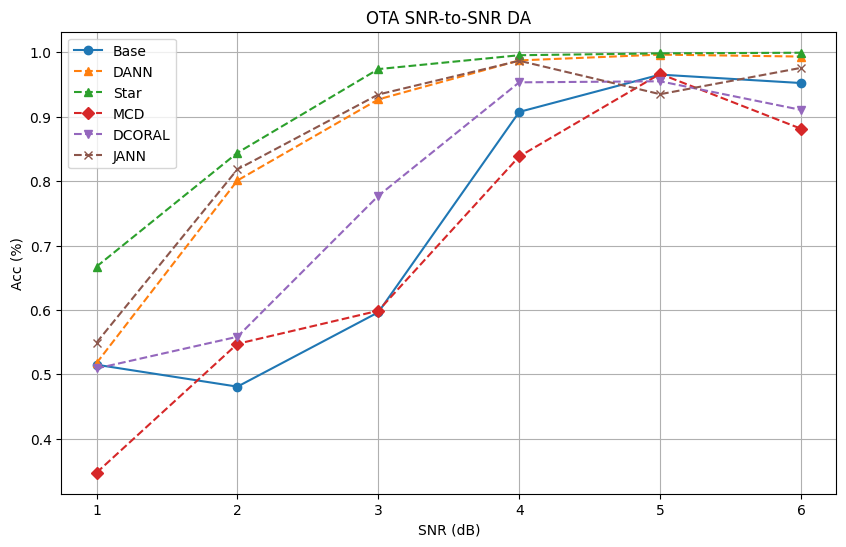

In [3]:
x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='^', linestyle='--', label='DANN')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='--', label='DCORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.title('OTA SNR-to-SNR DA')
plt.show()

In [4]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/sim_X.npy")
Y = np.load(file_path + "/sim_Y.npy")

sou_snr = 22
tar_snr = 10

t_deep_coral_acc = []
t_base_acc = []
t_dann_acc = []
t_mcd_acc = []
t_star_acc = []
t_jan_acc = []

n_runs = 10
n_epochs= 50
lr = 0.001
n_snr= 4

for i in range(n_snr):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, batch_size=128, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, batch_size=128, permute=False)

    print('Base')
    _, t_base = base.Base(
        model_cls=DeepResNet,
        device=device,
        S_train_loader=S_train_loader, 
        S_val_loader=S_val_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset, 
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_base_acc.append(t_base)

    print('DANN')
    _, t_dann = dann.DAN(
        dann.DANN,
        FA=DANN_F,
        LP=DANN_LP,
        DC=DANN_DC,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_dann_acc.append(t_dann)

    print('Deep CORAL')
    _, t_deep = DeepCORAL(
        G=CORAL_G, 
        C=CORAL_C, 
        device=device, 
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr, 
        n_epochs=n_epochs, 
        n_runs=n_runs,
        patience=5,
        lambda_coral=0.5,
        deep_weights=(1.0, 1.0, 1.0)
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_deep_coral_acc.append(t_deep)

    print('STAR')
    _, t_star =  star.Star(
        G=STAR_G,
        C=STAR_C,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,  
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs,
        patience=5
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_star_acc.append(t_star)

    print('MCD')
    _, t_mcd = mcd.Mcd(
        G=MCD_G,
        C=MCD_C,
        device=device,
        S_train_loader=S_train_loader,
        S_val_loader=S_val_loader,  
        T_train_loader=T_train_loader,
        T_val_loader=T_val_loader,
        class_subset=class_subset,
        n_classes=len(class_subset),
        lr=lr,
        n_epochs=n_epochs,
        n_runs=n_runs,
        patience=5
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_mcd_acc.append(t_mcd)

    print('JAN')
    _, t_jan = jan.Jan(
        C=C_JAN,
        G=JAN_G,
        num_classes=len(class_subset),
        device=device,
        S_train_loader=S_train_loader,
        T_train_loader=T_train_loader,
        S_val_loader=S_val_loader,
        T_val_loader=T_val_loader,
        n_epochs=n_epochs,
        lr=lr,
        lambda_jmmd=0.1,
        n_runs=n_runs
    ).run()
    torch.cuda.empty_cache()
    #s_deep_coral_acc.append(s_deep)
    t_jan_acc.append(t_jan)
    
    tar_snr += 4

Base

Run 1/10
Epoch 1/50, Train Loss: 0.3820, Train Acc: 0.8464, Val Loss: 2.3482, Val Acc: 0.7650
Epoch 2/50, Train Loss: 0.1123, Train Acc: 0.9610, Val Loss: 0.4687, Val Acc: 0.8501
Epoch 3/50, Train Loss: 0.0435, Train Acc: 0.9858, Val Loss: 0.5571, Val Acc: 0.8489
Epoch 4/50, Train Loss: 0.0202, Train Acc: 0.9936, Val Loss: 1.0855, Val Acc: 0.7092
Epoch 5/50, Train Loss: 0.0207, Train Acc: 0.9934, Val Loss: 0.0150, Val Acc: 0.9958
Epoch 6/50, Train Loss: 0.0102, Train Acc: 0.9975, Val Loss: 0.0151, Val Acc: 0.9964
Epoch 7/50, Train Loss: 0.0024, Train Acc: 0.9994, Val Loss: 0.0112, Val Acc: 0.9958
Epoch 8/50, Train Loss: 0.0047, Train Acc: 0.9984, Val Loss: 0.0256, Val Acc: 0.9904
Epoch 9/50, Train Loss: 0.0080, Train Acc: 0.9981, Val Loss: 0.0551, Val Acc: 0.9808
Epoch 10/50, Train Loss: 0.0036, Train Acc: 0.9993, Val Loss: 0.0140, Val Acc: 0.9940
Epoch 11/50, Train Loss: 0.0012, Train Acc: 0.9999, Val Loss: 0.0035, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0022, Train Acc: 0.99

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4216, Train Acc: 0.8308, Val Loss: 3.7897, Val Acc: 0.6835
Epoch 2/50, Train Loss: 0.1014, Train Acc: 0.9640, Val Loss: 0.4131, Val Acc: 0.8675
Epoch 3/50, Train Loss: 0.0310, Train Acc: 0.9912, Val Loss: 0.3290, Val Acc: 0.9035
Epoch 4/50, Train Loss: 0.0112, Train Acc: 0.9976, Val Loss: 0.4464, Val Acc: 0.8483
Epoch 5/50, Train Loss: 0.0039, Train Acc: 0.9991, Val Loss: 0.4705, Val Acc: 0.8585
Epoch 6/50, Train Loss: 0.0055, Train Acc: 0.9985, Val Loss: 10.6719, Val Acc: 0.4988
Epoch 7/50, Train Loss: 0.0078, Train Acc: 0.9981, Val Loss: 0.0022, Val Acc: 0.9994
Epoch 8/50, Train Loss: 0.0041, Train Acc: 0.9991, Val Loss: 0.0114, Val Acc: 0.9964
Epoch 9/50, Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0002, Val Acc: 1.0000
Epoch 10/50, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0002, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3807, Train Acc: 0.8514, Val Loss: 3.1374, Val Acc: 0.7128
Epoch 2/50, Train Loss: 0.0902, Train Acc: 0.9682, Val Loss: 2.4593, Val Acc: 0.6918
Epoch 3/50, Train Loss: 0.0385, Train Acc: 0.9871, Val Loss: 0.3241, Val Acc: 0.9053
Epoch 4/50, Train Loss: 0.0260, Train Acc: 0.9921, Val Loss: 16.1177, Val Acc: 0.4976
Epoch 5/50, Train Loss: 0.0194, Train Acc: 0.9939, Val Loss: 2.2224, Val Acc: 0.5629
Epoch 6/50, Train Loss: 0.0068, Train Acc: 0.9978, Val Loss: 0.6876, Val Acc: 0.7308
Epoch 7/50, Train Loss: 0.0051, Train Acc: 0.9987, Val Loss: 0.0398, Val Acc: 0.9886
Epoch 8/50, Train Loss: 0.0026, Train Acc: 0.9990, Val Loss: 0.0088, Val Acc: 0.9970
Epoch 9/50, Train Loss: 0.0007, Train Acc: 0.9999, Val Loss: 0.0046, Val Acc: 0.9982
Epoch 10/50, Train Loss: 0.0021, Train Acc: 0.9999, Val Loss: 0.0041, Val Acc: 0.9982
Epoch 11/50, Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0036, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4137, Train Acc: 0.8281, Val Loss: 1.7389, Val Acc: 0.7560
Epoch 2/50, Train Loss: 0.1079, Train Acc: 0.9622, Val Loss: 0.2859, Val Acc: 0.9059
Epoch 3/50, Train Loss: 0.0530, Train Acc: 0.9819, Val Loss: 1.0347, Val Acc: 0.7872
Epoch 4/50, Train Loss: 0.0270, Train Acc: 0.9919, Val Loss: 0.1144, Val Acc: 0.9598
Epoch 5/50, Train Loss: 0.0166, Train Acc: 0.9952, Val Loss: 0.1033, Val Acc: 0.9598
Epoch 6/50, Train Loss: 0.0109, Train Acc: 0.9967, Val Loss: 12.5898, Val Acc: 0.6871
Epoch 7/50, Train Loss: 0.0113, Train Acc: 0.9964, Val Loss: 0.0059, Val Acc: 0.9976
Epoch 8/50, Train Loss: 0.0052, Train Acc: 0.9985, Val Loss: 1.7388, Val Acc: 0.7536
Epoch 9/50, Train Loss: 0.0030, Train Acc: 0.9996, Val Loss: 0.0015, Val Acc: 0.9994
Epoch 10/50, Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0003, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0003, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4679, Train Acc: 0.8062, Val Loss: 16.0356, Val Acc: 0.2512
Epoch 2/50, Train Loss: 0.1509, Train Acc: 0.9394, Val Loss: 0.3044, Val Acc: 0.8771
Epoch 3/50, Train Loss: 0.0537, Train Acc: 0.9828, Val Loss: 0.2987, Val Acc: 0.8969
Epoch 4/50, Train Loss: 0.0151, Train Acc: 0.9957, Val Loss: 0.0270, Val Acc: 0.9898
Epoch 5/50, Train Loss: 0.0107, Train Acc: 0.9966, Val Loss: 0.2941, Val Acc: 0.9185
Epoch 6/50, Train Loss: 0.0139, Train Acc: 0.9954, Val Loss: 1.3920, Val Acc: 0.7770
Epoch 7/50, Train Loss: 0.0098, Train Acc: 0.9969, Val Loss: 0.0289, Val Acc: 0.9892
Epoch 8/50, Train Loss: 0.0094, Train Acc: 0.9978, Val Loss: 0.0856, Val Acc: 0.9946
Epoch 9/50, Train Loss: 0.0054, Train Acc: 0.9985, Val Loss: 0.0255, Val Acc: 0.9904
Epoch 10/50, Train Loss: 0.0037, Train Acc: 0.9988, Val Loss: 0.0089, Val Acc: 0.9958
Epoch 11/50, Train Loss: 0.0021, Train Acc: 0.9996, Val Loss: 0.0076, Val Acc: 0.9970
Epoch 12/50, Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4253, Train Acc: 0.8347, Val Loss: 3.9403, Val Acc: 0.5528
Epoch 2/50, Train Loss: 0.0869, Train Acc: 0.9702, Val Loss: 0.6039, Val Acc: 0.8411
Epoch 3/50, Train Loss: 0.0715, Train Acc: 0.9757, Val Loss: 0.3173, Val Acc: 0.8885
Epoch 4/50, Train Loss: 0.0275, Train Acc: 0.9910, Val Loss: 0.3111, Val Acc: 0.8837
Epoch 5/50, Train Loss: 0.0137, Train Acc: 0.9966, Val Loss: 0.8450, Val Acc: 0.7752
Epoch 6/50, Train Loss: 0.0140, Train Acc: 0.9952, Val Loss: 0.1225, Val Acc: 0.9592
Epoch 7/50, Train Loss: 0.0105, Train Acc: 0.9972, Val Loss: 0.0176, Val Acc: 0.9916
Epoch 8/50, Train Loss: 0.0030, Train Acc: 0.9994, Val Loss: 0.0105, Val Acc: 0.9964
Epoch 9/50, Train Loss: 0.0014, Train Acc: 0.9996, Val Loss: 0.0081, Val Acc: 0.9982
Epoch 10/50, Train Loss: 0.0036, Train Acc: 0.9988, Val Loss: 3.8596, Val Acc: 0.7074
Epoch 11/50, Train Loss: 0.0035, Train Acc: 0.9994, Val Loss: 0.0088, Val Acc: 0.9964
Epoch 12/50, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4239, Train Acc: 0.8221, Val Loss: 0.5578, Val Acc: 0.8177
Epoch 2/50, Train Loss: 0.1252, Train Acc: 0.9531, Val Loss: 0.2865, Val Acc: 0.8705
Epoch 3/50, Train Loss: 0.0668, Train Acc: 0.9751, Val Loss: 0.4466, Val Acc: 0.8327
Epoch 4/50, Train Loss: 0.0386, Train Acc: 0.9871, Val Loss: 1.2201, Val Acc: 0.7854
Epoch 5/50, Train Loss: 0.0223, Train Acc: 0.9928, Val Loss: 0.0327, Val Acc: 0.9904
Epoch 6/50, Train Loss: 0.0110, Train Acc: 0.9975, Val Loss: 0.1114, Val Acc: 0.9628
Epoch 7/50, Train Loss: 0.0051, Train Acc: 0.9987, Val Loss: 0.0134, Val Acc: 0.9958
Epoch 8/50, Train Loss: 0.0112, Train Acc: 0.9976, Val Loss: 5.6848, Val Acc: 0.5600
Epoch 9/50, Train Loss: 0.0082, Train Acc: 0.9985, Val Loss: 0.6367, Val Acc: 0.8753
Epoch 10/50, Train Loss: 0.0029, Train Acc: 0.9991, Val Loss: 0.0062, Val Acc: 0.9976
Epoch 11/50, Train Loss: 0.0015, Train Acc: 0.9997, Val Loss: 0.0033, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0010, Train Acc: 0.9999, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4167, Train Acc: 0.8359, Val Loss: 7.4548, Val Acc: 0.4934
Epoch 2/50, Train Loss: 0.1304, Train Acc: 0.9493, Val Loss: 0.0782, Val Acc: 0.9712
Epoch 3/50, Train Loss: 0.0494, Train Acc: 0.9832, Val Loss: 0.1502, Val Acc: 0.9496
Epoch 4/50, Train Loss: 0.0224, Train Acc: 0.9928, Val Loss: 0.0145, Val Acc: 0.9946
Epoch 5/50, Train Loss: 0.0175, Train Acc: 0.9948, Val Loss: 0.2575, Val Acc: 0.9215
Epoch 6/50, Train Loss: 0.0114, Train Acc: 0.9966, Val Loss: 0.0936, Val Acc: 0.9694
Epoch 7/50, Train Loss: 0.0047, Train Acc: 0.9987, Val Loss: 0.0491, Val Acc: 0.9814
Epoch 8/50, Train Loss: 0.0018, Train Acc: 0.9996, Val Loss: 0.0104, Val Acc: 0.9952
Epoch 9/50, Train Loss: 0.0050, Train Acc: 0.9985, Val Loss: 0.4941, Val Acc: 0.8771
Epoch 10/50, Train Loss: 0.0123, Train Acc: 0.9955, Val Loss: 0.2990, Val Acc: 0.9203
Epoch 11/50, Train Loss: 0.0048, Train Acc: 0.9991, Val Loss: 0.0096, Val Acc: 0.9982
Epoch 12/50, Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2964, Domain Loss: 1.3158, Class Loss: 0.9806
Epoch 2/50, Loss: 1.8903, Domain Loss: 1.4565, Class Loss: 0.4338
Epoch 3/50, Loss: 2.4818, Domain Loss: 2.1027, Class Loss: 0.3790
Epoch 4/50, Loss: 10.6560, Domain Loss: 10.2819, Class Loss: 0.3741
Epoch 5/50, Loss: 7.5426, Domain Loss: 7.1788, Class Loss: 0.3638
Epoch 6/50, Loss: 12.8229, Domain Loss: 12.3427, Class Loss: 0.4802
Epoch 7/50, Loss: 10.8920, Domain Loss: 10.4370, Class Loss: 0.4550
Epoch 8/50, Loss: 4.1137, Domain Loss: 3.4502, Class Loss: 0.6635
Epoch 9/50, Loss: 2.5998, Domain Loss: 2.0767, Class Loss: 0.5231
Epoch 10/50, Loss: 2.1911, Domain Loss: 1.7510, Class Loss: 0.4400
Epoch 11/50, Loss: 1.9348, Domain Loss: 1.5613, Class Loss: 0.3735
Epoch 12/50, Loss: 2.6355, Domain Loss: 2.2502, Class Loss: 0.3853
Epoch 13/50, Loss: 2.6605, Domain Loss: 2.2600, Class Loss: 0.4005
Epoch 14/50, Loss: 2.9323, Domain Loss: 2.5065, Class Loss: 0.4258
Epoch 15/50, Loss: 3.8034, Domain Loss: 3.1482, Class Loss: 0.655

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2118, Domain Loss: 1.3230, Class Loss: 0.8888
Epoch 2/50, Loss: 1.6626, Domain Loss: 1.2337, Class Loss: 0.4289
Epoch 3/50, Loss: 2.2288, Domain Loss: 1.8401, Class Loss: 0.3887
Epoch 4/50, Loss: 7.0137, Domain Loss: 6.6059, Class Loss: 0.4078
Epoch 5/50, Loss: 7.6845, Domain Loss: 7.2667, Class Loss: 0.4179
Epoch 6/50, Loss: 5.7102, Domain Loss: 5.3909, Class Loss: 0.3193
Epoch 7/50, Loss: 15.8873, Domain Loss: 15.4536, Class Loss: 0.4336
Epoch 8/50, Loss: 27.9675, Domain Loss: 27.1221, Class Loss: 0.8454
Epoch 9/50, Loss: 44.9700, Domain Loss: 43.9483, Class Loss: 1.0218
Epoch 10/50, Loss: 10.9192, Domain Loss: 10.2893, Class Loss: 0.6300
Epoch 11/50, Loss: 6.3422, Domain Loss: 5.5336, Class Loss: 0.8086
Epoch 12/50, Loss: 2.9245, Domain Loss: 2.3450, Class Loss: 0.5794
Epoch 13/50, Loss: 2.4964, Domain Loss: 1.9771, Class Loss: 0.5193
Epoch 14/50, Loss: 2.3550, Domain Loss: 1.9132, Class Loss: 0.4418
Epoch 15/50, Loss: 2.8526, Domain Loss: 2.4390, Class Loss: 0.4

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2351, Domain Loss: 1.3134, Class Loss: 0.9217
Epoch 2/50, Loss: 1.8398, Domain Loss: 1.3807, Class Loss: 0.4591
Epoch 3/50, Loss: 4.4383, Domain Loss: 3.9981, Class Loss: 0.4402
Epoch 4/50, Loss: 7.4546, Domain Loss: 7.0534, Class Loss: 0.4013
Epoch 5/50, Loss: 6.3911, Domain Loss: 6.0136, Class Loss: 0.3775
Epoch 6/50, Loss: 3.7598, Domain Loss: 3.4672, Class Loss: 0.2926
Epoch 7/50, Loss: 4.2512, Domain Loss: 3.8471, Class Loss: 0.4041
Epoch 8/50, Loss: 2.6366, Domain Loss: 2.3082, Class Loss: 0.3284
Epoch 9/50, Loss: 1.8008, Domain Loss: 1.5045, Class Loss: 0.2963
Epoch 10/50, Loss: 2.6571, Domain Loss: 2.4329, Class Loss: 0.2242
Epoch 11/50, Loss: 2.2428, Domain Loss: 2.0260, Class Loss: 0.2168
Epoch 12/50, Loss: 1.6282, Domain Loss: 1.4528, Class Loss: 0.1754
Epoch 13/50, Loss: 1.8014, Domain Loss: 1.6002, Class Loss: 0.2011
Epoch 14/50, Loss: 1.7940, Domain Loss: 1.6315, Class Loss: 0.1624
Epoch 15/50, Loss: 1.9443, Domain Loss: 1.8251, Class Loss: 0.1192
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2233, Domain Loss: 1.3264, Class Loss: 0.8969
Epoch 2/50, Loss: 1.7161, Domain Loss: 1.2967, Class Loss: 0.4194
Epoch 3/50, Loss: 2.0564, Domain Loss: 1.7180, Class Loss: 0.3383
Epoch 4/50, Loss: 3.4694, Domain Loss: 3.1585, Class Loss: 0.3108
Epoch 5/50, Loss: 5.0754, Domain Loss: 4.8066, Class Loss: 0.2688
Epoch 6/50, Loss: 4.0444, Domain Loss: 3.7639, Class Loss: 0.2805
Epoch 7/50, Loss: 4.2909, Domain Loss: 4.0950, Class Loss: 0.1959
Epoch 8/50, Loss: 5.4140, Domain Loss: 5.1388, Class Loss: 0.2752
Epoch 9/50, Loss: 7.5961, Domain Loss: 6.9379, Class Loss: 0.6582
Epoch 10/50, Loss: 13.7518, Domain Loss: 13.0272, Class Loss: 0.7246
Epoch 11/50, Loss: 8.1697, Domain Loss: 7.5926, Class Loss: 0.5771
Epoch 12/50, Loss: 5.8523, Domain Loss: 5.3311, Class Loss: 0.5212
Epoch 13/50, Loss: 3.9869, Domain Loss: 3.5012, Class Loss: 0.4857
Epoch 14/50, Loss: 4.8488, Domain Loss: 4.4002, Class Loss: 0.4486
Epoch 15/50, Loss: 12.9014, Domain Loss: 12.3180, Class Loss: 0.5834


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2454, Domain Loss: 1.3143, Class Loss: 0.9311
Epoch 2/50, Loss: 1.9726, Domain Loss: 1.5092, Class Loss: 0.4633
Epoch 3/50, Loss: 3.5706, Domain Loss: 3.1481, Class Loss: 0.4225
Epoch 4/50, Loss: 12.2438, Domain Loss: 11.8584, Class Loss: 0.3854
Epoch 5/50, Loss: 17.0744, Domain Loss: 16.6873, Class Loss: 0.3871
Epoch 6/50, Loss: 17.7589, Domain Loss: 17.0991, Class Loss: 0.6598
Epoch 7/50, Loss: 39.8803, Domain Loss: 39.3968, Class Loss: 0.4835
Epoch 8/50, Loss: 17.1722, Domain Loss: 16.6909, Class Loss: 0.4813
Epoch 9/50, Loss: 11.2341, Domain Loss: 10.7912, Class Loss: 0.4428
Epoch 10/50, Loss: 3.9603, Domain Loss: 3.5930, Class Loss: 0.3674
Epoch 11/50, Loss: 2.2563, Domain Loss: 1.9071, Class Loss: 0.3493
Epoch 12/50, Loss: 1.7602, Domain Loss: 1.4702, Class Loss: 0.2900
Epoch 13/50, Loss: 1.6359, Domain Loss: 1.3940, Class Loss: 0.2419
Epoch 14/50, Loss: 1.8484, Domain Loss: 1.6057, Class Loss: 0.2427
Epoch 15/50, Loss: 2.1031, Domain Loss: 1.8410, Class Loss:

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2161, Domain Loss: 1.3267, Class Loss: 0.8894
Epoch 2/50, Loss: 1.6946, Domain Loss: 1.2578, Class Loss: 0.4368
Epoch 3/50, Loss: 2.9435, Domain Loss: 2.5732, Class Loss: 0.3702
Epoch 4/50, Loss: 4.6937, Domain Loss: 4.3270, Class Loss: 0.3667
Epoch 5/50, Loss: 12.1799, Domain Loss: 11.7965, Class Loss: 0.3833
Epoch 6/50, Loss: 5.9437, Domain Loss: 5.5608, Class Loss: 0.3829
Epoch 7/50, Loss: 3.6910, Domain Loss: 3.3195, Class Loss: 0.3715
Epoch 8/50, Loss: 3.8074, Domain Loss: 3.2892, Class Loss: 0.5182
Epoch 9/50, Loss: 6.4347, Domain Loss: 5.8547, Class Loss: 0.5799
Epoch 10/50, Loss: 6.7048, Domain Loss: 6.2295, Class Loss: 0.4753
Epoch 11/50, Loss: 9.0724, Domain Loss: 8.7025, Class Loss: 0.3698
Epoch 12/50, Loss: 6.3211, Domain Loss: 5.9079, Class Loss: 0.4132
Epoch 13/50, Loss: 7.1909, Domain Loss: 6.4614, Class Loss: 0.7295
Epoch 14/50, Loss: 5.1156, Domain Loss: 4.5016, Class Loss: 0.6140
Epoch 15/50, Loss: 7.5765, Domain Loss: 7.0617, Class Loss: 0.5148
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.3041, Domain Loss: 1.3296, Class Loss: 0.9745
Epoch 2/50, Loss: 1.8352, Domain Loss: 1.3944, Class Loss: 0.4408
Epoch 3/50, Loss: 2.7353, Domain Loss: 2.3036, Class Loss: 0.4317
Epoch 4/50, Loss: 5.7098, Domain Loss: 5.3440, Class Loss: 0.3657
Epoch 5/50, Loss: 13.5518, Domain Loss: 13.1267, Class Loss: 0.4252
Epoch 6/50, Loss: 6.1286, Domain Loss: 5.6528, Class Loss: 0.4757
Epoch 7/50, Loss: 4.0483, Domain Loss: 3.6588, Class Loss: 0.3895
Epoch 8/50, Loss: 4.4703, Domain Loss: 4.0501, Class Loss: 0.4203
Epoch 9/50, Loss: 3.8334, Domain Loss: 3.4277, Class Loss: 0.4057
Epoch 10/50, Loss: 2.8626, Domain Loss: 2.5763, Class Loss: 0.2863
Epoch 11/50, Loss: 2.6505, Domain Loss: 2.3583, Class Loss: 0.2922
Epoch 12/50, Loss: 2.3899, Domain Loss: 2.0891, Class Loss: 0.3008
Epoch 13/50, Loss: 2.0772, Domain Loss: 1.7288, Class Loss: 0.3485
Epoch 14/50, Loss: 1.8271, Domain Loss: 1.5181, Class Loss: 0.3090
Epoch 15/50, Loss: 1.7877, Domain Loss: 1.5738, Class Loss: 0.2139
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Source Val Acc = 0.7020, Target Val Acc = 0.3429
Epoch 2: Source Val Acc = 0.5174, Target Val Acc = 0.4514
Epoch 3: Source Val Acc = 0.5180, Target Val Acc = 0.4946
Epoch 4: Source Val Acc = 0.5264, Target Val Acc = 0.5252
Epoch 5: Source Val Acc = 0.5264, Target Val Acc = 0.5102
Epoch 6: Source Val Acc = 0.5168, Target Val Acc = 0.3477
Early stopping triggered.
Run 1 finished: Best Source Val Acc = 0.5168, Target Val Acc = 0.3477

Deep CORAL Run 2/10
Epoch 1: Source Val Acc = 0.6571, Target Val Acc = 0.5510
Epoch 2: Source Val Acc = 0.5534, Target Val Acc = 0.5390
Epoch 3: Source Val Acc = 0.5234, Target Val Acc = 0.4484
Epoch 4: Source Val Acc = 0.4089, Target Val Acc = 0.2806
Epoch 5: Source Val Acc = 0.7656, Target Val Acc = 0.4538
Epoch 6: Source Val Acc = 0.7626, Target Val Acc = 0.4460
Epoch 7: Source Val Acc = 0.5348, Target Val Acc = 0.4568
Epoch 8: Source Val Acc = 0.6037, Target Val Acc = 0.5084
Epoch 9: Source Val Acc = 0.7164, Target Val Acc = 0.4490
Epoch 10: Sou

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4131, Train Acc: 0.8403, Val Loss: 1.3051, Val Acc: 0.7458
Epoch 2/50, Train Loss: 0.1076, Train Acc: 0.9631, Val Loss: 0.9590, Val Acc: 0.7854
Epoch 3/50, Train Loss: 0.0924, Train Acc: 0.9693, Val Loss: 0.0677, Val Acc: 0.9760
Epoch 4/50, Train Loss: 0.0241, Train Acc: 0.9934, Val Loss: 2.5287, Val Acc: 0.7104
Epoch 5/50, Train Loss: 0.0422, Train Acc: 0.9871, Val Loss: 0.7091, Val Acc: 0.8129
Epoch 6/50, Train Loss: 0.0181, Train Acc: 0.9937, Val Loss: 0.0154, Val Acc: 0.9964
Epoch 7/50, Train Loss: 0.0091, Train Acc: 0.9978, Val Loss: 0.1860, Val Acc: 0.9371
Epoch 8/50, Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 9/50, Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 10/50, Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0003, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0005, Train Acc: 0.9999, Val Loss: 0.0002, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4312, Train Acc: 0.8340, Val Loss: 3.9367, Val Acc: 0.7362
Epoch 2/50, Train Loss: 0.1375, Train Acc: 0.9484, Val Loss: 1.6524, Val Acc: 0.7536
Epoch 3/50, Train Loss: 0.0562, Train Acc: 0.9805, Val Loss: 4.7066, Val Acc: 0.5689
Epoch 4/50, Train Loss: 0.0347, Train Acc: 0.9894, Val Loss: 5.6173, Val Acc: 0.5444
Epoch 5/50, Train Loss: 0.0313, Train Acc: 0.9879, Val Loss: 0.1007, Val Acc: 0.9616
Epoch 6/50, Train Loss: 0.0142, Train Acc: 0.9948, Val Loss: 1.2922, Val Acc: 0.7770
Epoch 7/50, Train Loss: 0.0033, Train Acc: 0.9993, Val Loss: 0.0177, Val Acc: 0.9940
Epoch 8/50, Train Loss: 0.0028, Train Acc: 0.9994, Val Loss: 0.0171, Val Acc: 0.9952
Epoch 9/50, Train Loss: 0.0145, Train Acc: 0.9973, Val Loss: 0.0046, Val Acc: 0.9982
Epoch 10/50, Train Loss: 0.0062, Train Acc: 0.9984, Val Loss: 1.4031, Val Acc: 0.7680
Epoch 11/50, Train Loss: 0.0029, Train Acc: 0.9993, Val Loss: 0.0018, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0011, Train Acc: 0.9999, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4037, Train Acc: 0.8370, Val Loss: 3.5396, Val Acc: 0.5917
Epoch 2/50, Train Loss: 0.0984, Train Acc: 0.9639, Val Loss: 0.9710, Val Acc: 0.7260
Epoch 3/50, Train Loss: 0.0507, Train Acc: 0.9829, Val Loss: 0.1658, Val Acc: 0.9388
Epoch 4/50, Train Loss: 0.0212, Train Acc: 0.9937, Val Loss: 0.4856, Val Acc: 0.8423
Epoch 5/50, Train Loss: 0.0200, Train Acc: 0.9942, Val Loss: 1.7876, Val Acc: 0.7482
Epoch 6/50, Train Loss: 0.0168, Train Acc: 0.9942, Val Loss: 0.0220, Val Acc: 0.9922
Epoch 7/50, Train Loss: 0.0110, Train Acc: 0.9967, Val Loss: 2.1049, Val Acc: 0.7572
Epoch 8/50, Train Loss: 0.0059, Train Acc: 0.9984, Val Loss: 0.1187, Val Acc: 0.9628
Epoch 9/50, Train Loss: 0.0016, Train Acc: 0.9997, Val Loss: 0.0031, Val Acc: 0.9994
Epoch 10/50, Train Loss: 0.0020, Train Acc: 0.9997, Val Loss: 0.1501, Val Acc: 0.9466
Epoch 11/50, Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0009, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0007, Train Acc: 0.9999, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3995, Train Acc: 0.8367, Val Loss: 0.2385, Val Acc: 0.9227
Epoch 2/50, Train Loss: 0.0868, Train Acc: 0.9678, Val Loss: 2.3175, Val Acc: 0.7350
Epoch 3/50, Train Loss: 0.0497, Train Acc: 0.9831, Val Loss: 0.0421, Val Acc: 0.9868
Epoch 4/50, Train Loss: 0.0224, Train Acc: 0.9924, Val Loss: 0.3807, Val Acc: 0.9077
Epoch 5/50, Train Loss: 0.0105, Train Acc: 0.9969, Val Loss: 0.0184, Val Acc: 0.9928
Epoch 6/50, Train Loss: 0.0041, Train Acc: 0.9993, Val Loss: 0.8833, Val Acc: 0.7680
Epoch 7/50, Train Loss: 0.0083, Train Acc: 0.9969, Val Loss: 0.0188, Val Acc: 0.9928
Epoch 8/50, Train Loss: 0.0115, Train Acc: 0.9964, Val Loss: 0.0936, Val Acc: 0.9700
Epoch 9/50, Train Loss: 0.0042, Train Acc: 0.9988, Val Loss: 0.0105, Val Acc: 0.9970
Epoch 10/50, Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.0012, Val Acc: 1.0000
Epoch 11/50, Train Loss: 0.0013, Train Acc: 0.9997, Val Loss: 0.0026, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4560, Train Acc: 0.8089, Val Loss: 1.7027, Val Acc: 0.6942
Epoch 2/50, Train Loss: 0.1442, Train Acc: 0.9456, Val Loss: 0.1736, Val Acc: 0.9305
Epoch 3/50, Train Loss: 0.0685, Train Acc: 0.9766, Val Loss: 3.1057, Val Acc: 0.5024
Epoch 4/50, Train Loss: 0.0638, Train Acc: 0.9774, Val Loss: 4.6650, Val Acc: 0.5036
Epoch 5/50, Train Loss: 0.0360, Train Acc: 0.9877, Val Loss: 0.0419, Val Acc: 0.9868
Epoch 6/50, Train Loss: 0.0120, Train Acc: 0.9963, Val Loss: 0.0121, Val Acc: 0.9970
Epoch 7/50, Train Loss: 0.0076, Train Acc: 0.9982, Val Loss: 0.5208, Val Acc: 0.8459
Epoch 8/50, Train Loss: 0.0070, Train Acc: 0.9982, Val Loss: 1.5857, Val Acc: 0.7224
Epoch 9/50, Train Loss: 0.0026, Train Acc: 0.9994, Val Loss: 0.1013, Val Acc: 0.9610
Epoch 10/50, Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 1.4275, Val Acc: 0.7530
Epoch 11/50, Train Loss: 0.0011, Train Acc: 0.9997, Val Loss: 0.0003, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4262, Train Acc: 0.8271, Val Loss: 3.4210, Val Acc: 0.5911
Epoch 2/50, Train Loss: 0.1226, Train Acc: 0.9546, Val Loss: 0.0553, Val Acc: 0.9790
Epoch 3/50, Train Loss: 0.0635, Train Acc: 0.9771, Val Loss: 0.2889, Val Acc: 0.8927
Epoch 4/50, Train Loss: 0.0382, Train Acc: 0.9876, Val Loss: 3.1701, Val Acc: 0.7518
Epoch 5/50, Train Loss: 0.0178, Train Acc: 0.9945, Val Loss: 6.0411, Val Acc: 0.5917
Epoch 6/50, Train Loss: 0.0112, Train Acc: 0.9973, Val Loss: 0.0856, Val Acc: 0.9688
Epoch 7/50, Train Loss: 0.0055, Train Acc: 0.9982, Val Loss: 0.0157, Val Acc: 0.9952
Epoch 8/50, Train Loss: 0.0148, Train Acc: 0.9954, Val Loss: 0.2266, Val Acc: 0.9227
Epoch 9/50, Train Loss: 0.0035, Train Acc: 0.9993, Val Loss: 0.0351, Val Acc: 0.9874
Epoch 10/50, Train Loss: 0.0037, Train Acc: 0.9993, Val Loss: 0.7469, Val Acc: 0.8046
Epoch 11/50, Train Loss: 0.0010, Train Acc: 0.9999, Val Loss: 0.0006, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4526, Train Acc: 0.8209, Val Loss: 2.6663, Val Acc: 0.7392
Epoch 2/50, Train Loss: 0.1046, Train Acc: 0.9610, Val Loss: 0.1778, Val Acc: 0.9388
Epoch 3/50, Train Loss: 0.0802, Train Acc: 0.9730, Val Loss: 20.1656, Val Acc: 0.5072
Epoch 4/50, Train Loss: 0.0404, Train Acc: 0.9862, Val Loss: 1.4310, Val Acc: 0.7758
Epoch 5/50, Train Loss: 0.0284, Train Acc: 0.9898, Val Loss: 2.4841, Val Acc: 0.5743
Epoch 6/50, Train Loss: 0.0118, Train Acc: 0.9961, Val Loss: 0.0173, Val Acc: 0.9946
Epoch 7/50, Train Loss: 0.0065, Train Acc: 0.9981, Val Loss: 0.0131, Val Acc: 0.9946
Epoch 8/50, Train Loss: 0.0096, Train Acc: 0.9969, Val Loss: 1.0588, Val Acc: 0.8082
Epoch 9/50, Train Loss: 0.0046, Train Acc: 0.9988, Val Loss: 0.0105, Val Acc: 0.9976
Epoch 10/50, Train Loss: 0.0047, Train Acc: 0.9991, Val Loss: 0.0236, Val Acc: 0.9922
Epoch 11/50, Train Loss: 0.0013, Train Acc: 0.9999, Val Loss: 0.0023, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0009, Train Acc: 0.9999, Val Loss: 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.4084, Domain Loss: 1.3837, Class Loss: 1.0247
Epoch 2/50, Loss: 1.7233, Domain Loss: 1.2642, Class Loss: 0.4592
Epoch 3/50, Loss: 1.9679, Domain Loss: 1.5407, Class Loss: 0.4273
Epoch 4/50, Loss: 1.9962, Domain Loss: 1.6808, Class Loss: 0.3154
Epoch 5/50, Loss: 2.6318, Domain Loss: 2.3695, Class Loss: 0.2623
Epoch 6/50, Loss: 3.9681, Domain Loss: 3.7452, Class Loss: 0.2229
Epoch 7/50, Loss: 4.9134, Domain Loss: 4.5379, Class Loss: 0.3755
Epoch 8/50, Loss: 6.0642, Domain Loss: 5.6590, Class Loss: 0.4052
Epoch 9/50, Loss: 3.5945, Domain Loss: 3.0519, Class Loss: 0.5426
Epoch 10/50, Loss: 11.0973, Domain Loss: 10.5886, Class Loss: 0.5087
Epoch 11/50, Loss: 8.8410, Domain Loss: 8.1453, Class Loss: 0.6957
Epoch 12/50, Loss: 8.9778, Domain Loss: 8.1822, Class Loss: 0.7956
Epoch 13/50, Loss: 4.5040, Domain Loss: 3.9714, Class Loss: 0.5326
Epoch 14/50, Loss: 2.9345, Domain Loss: 2.4119, Class Loss: 0.5225
Epoch 15/50, Loss: 2.4005, Domain Loss: 1.9751, Class Loss: 0.4254
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.3504, Domain Loss: 1.3854, Class Loss: 0.9650
Epoch 2/50, Loss: 1.8020, Domain Loss: 1.3833, Class Loss: 0.4187
Epoch 3/50, Loss: 1.6806, Domain Loss: 1.3946, Class Loss: 0.2860
Epoch 4/50, Loss: 1.6587, Domain Loss: 1.4848, Class Loss: 0.1739
Epoch 5/50, Loss: 2.5525, Domain Loss: 2.3700, Class Loss: 0.1825
Epoch 6/50, Loss: 2.6634, Domain Loss: 2.3906, Class Loss: 0.2728
Epoch 7/50, Loss: 2.7415, Domain Loss: 2.4880, Class Loss: 0.2535
Epoch 8/50, Loss: 2.1974, Domain Loss: 2.0174, Class Loss: 0.1800
Epoch 9/50, Loss: 3.2747, Domain Loss: 3.0200, Class Loss: 0.2547
Epoch 10/50, Loss: 5.3747, Domain Loss: 5.0626, Class Loss: 0.3121
Epoch 11/50, Loss: 3.9297, Domain Loss: 3.4578, Class Loss: 0.4719
Epoch 12/50, Loss: 3.3058, Domain Loss: 2.6066, Class Loss: 0.6993
Epoch 13/50, Loss: 2.3423, Domain Loss: 1.7580, Class Loss: 0.5843
Epoch 14/50, Loss: 2.6166, Domain Loss: 2.0972, Class Loss: 0.5194
Epoch 15/50, Loss: 2.8972, Domain Loss: 2.3867, Class Loss: 0.5106
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Source Val Acc = 0.5492, Target Val Acc = 0.4784
Epoch 2: Source Val Acc = 0.5270, Target Val Acc = 0.5180
Epoch 3: Source Val Acc = 0.7926, Target Val Acc = 0.5336
Epoch 4: Source Val Acc = 0.8441, Target Val Acc = 0.6199
Epoch 5: Source Val Acc = 0.7158, Target Val Acc = 0.4143
Epoch 6: Source Val Acc = 0.8219, Target Val Acc = 0.4898
Epoch 7: Source Val Acc = 0.6241, Target Val Acc = 0.5959
Epoch 8: Source Val Acc = 0.6601, Target Val Acc = 0.5432
Epoch 9: Source Val Acc = 0.9496, Target Val Acc = 0.5390
Epoch 10: Source Val Acc = 0.9436, Target Val Acc = 0.5893
Epoch 11: Source Val Acc = 0.7530, Target Val Acc = 0.5132
Epoch 12: Source Val Acc = 0.7032, Target Val Acc = 0.6253
Epoch 13: Source Val Acc = 0.9544, Target Val Acc = 0.4880
Epoch 14: Source Val Acc = 0.9940, Target Val Acc = 0.5090
Epoch 15: Source Val Acc = 0.9814, Target Val Acc = 0.5618
Epoch 16: Source Val Acc = 0.9808, Target Val Acc = 0.5653
Epoch 17: Source Val Acc = 0.7332, Target Val Acc = 0.4880
Epoch 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.4174, Train Acc: 0.8311, Val Loss: 3.4097, Val Acc: 0.7554
Epoch 2/50, Train Loss: 0.1369, Train Acc: 0.9486, Val Loss: 0.5632, Val Acc: 0.8100
Epoch 3/50, Train Loss: 0.0772, Train Acc: 0.9714, Val Loss: 0.3007, Val Acc: 0.8813
Epoch 4/50, Train Loss: 0.0444, Train Acc: 0.9862, Val Loss: 0.3440, Val Acc: 0.8921
Epoch 5/50, Train Loss: 0.0295, Train Acc: 0.9903, Val Loss: 0.5836, Val Acc: 0.8076
Epoch 6/50, Train Loss: 0.0217, Train Acc: 0.9930, Val Loss: 1.1536, Val Acc: 0.7962
Epoch 7/50, Train Loss: 0.0140, Train Acc: 0.9955, Val Loss: 5.7833, Val Acc: 0.5414
Epoch 8/50, Train Loss: 0.0051, Train Acc: 0.9988, Val Loss: 0.0156, Val Acc: 0.9952
Epoch 9/50, Train Loss: 0.0039, Train Acc: 0.9988, Val Loss: 0.0657, Val Acc: 0.9820
Epoch 10/50, Train Loss: 0.0039, Train Acc: 0.9988, Val Loss: 0.0918, Val Acc: 0.9610
Epoch 11/50, Train Loss: 0.0010, Train Acc: 0.9999, Val Loss: 0.0014, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 0.3936, Train Acc: 0.8449, Val Loss: 2.6337, Val Acc: 0.7584
Epoch 2/50, Train Loss: 0.0949, Train Acc: 0.9652, Val Loss: 3.0741, Val Acc: 0.7614
Epoch 3/50, Train Loss: 0.0555, Train Acc: 0.9810, Val Loss: 3.1664, Val Acc: 0.6894
Epoch 4/50, Train Loss: 0.0252, Train Acc: 0.9909, Val Loss: 1.6064, Val Acc: 0.6912
Epoch 5/50, Train Loss: 0.0101, Train Acc: 0.9970, Val Loss: 0.0329, Val Acc: 0.9868
Epoch 6/50, Train Loss: 0.0134, Train Acc: 0.9963, Val Loss: 0.3790, Val Acc: 0.9023
Epoch 7/50, Train Loss: 0.0129, Train Acc: 0.9967, Val Loss: 0.2399, Val Acc: 0.9239
Epoch 8/50, Train Loss: 0.0055, Train Acc: 0.9981, Val Loss: 0.2070, Val Acc: 0.9376
Epoch 9/50, Train Loss: 0.0018, Train Acc: 0.9996, Val Loss: 0.0091, Val Acc: 0.9970
Epoch 10/50, Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0039, Val Acc: 0.9982
Epoch 11/50, Train Loss: 0.0028, Train Acc: 0.9999, Val Loss: 0.0021, Val Acc: 0.9994
Epoch 12/50, Train Loss: 0.0005, Train Acc: 0.9999, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.2469, Domain Loss: 1.3732, Class Loss: 0.8737
Epoch 2/50, Loss: 1.7247, Domain Loss: 1.2746, Class Loss: 0.4500
Epoch 3/50, Loss: 1.5767, Domain Loss: 1.2348, Class Loss: 0.3419
Epoch 4/50, Loss: 3.5687, Domain Loss: 3.2334, Class Loss: 0.3353
Epoch 5/50, Loss: 4.9612, Domain Loss: 4.6256, Class Loss: 0.3356
Epoch 6/50, Loss: 12.3418, Domain Loss: 11.6365, Class Loss: 0.7053
Epoch 7/50, Loss: 17.9398, Domain Loss: 17.3525, Class Loss: 0.5873
Epoch 8/50, Loss: 9.6603, Domain Loss: 9.1464, Class Loss: 0.5139
Epoch 9/50, Loss: 4.7483, Domain Loss: 4.3298, Class Loss: 0.4185
Epoch 10/50, Loss: 2.4990, Domain Loss: 2.0317, Class Loss: 0.4673
Epoch 11/50, Loss: 2.4283, Domain Loss: 1.9879, Class Loss: 0.4404
Epoch 12/50, Loss: 2.2159, Domain Loss: 1.7860, Class Loss: 0.4299
Epoch 13/50, Loss: 3.4347, Domain Loss: 3.0194, Class Loss: 0.4153
Epoch 14/50, Loss: 11.2623, Domain Loss: 10.6179, Class Loss: 0.6444
Epoch 15/50, Loss: 7.9464, Domain Loss: 7.4958, Class Loss: 0.450

4
4


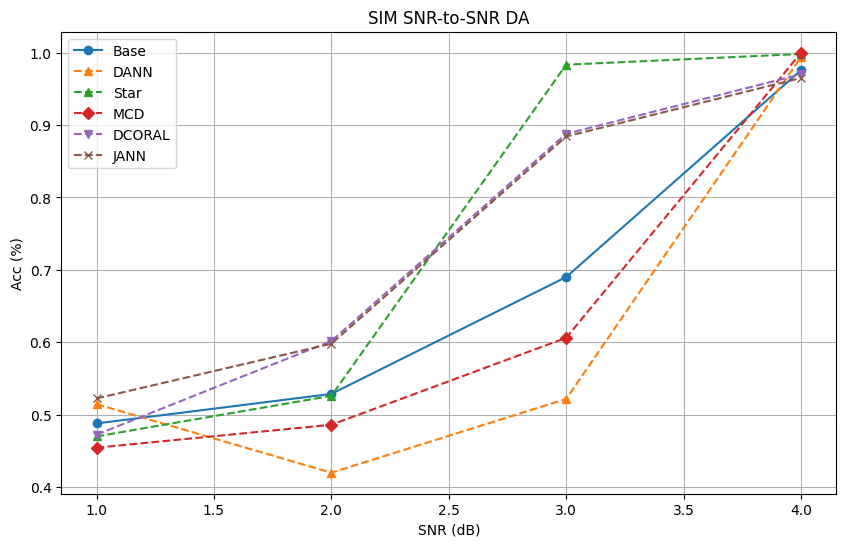

In [5]:
x = np.arange(1, n_snr+1)
print(len(t_deep_coral_acc))
print(len(x))

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='^', linestyle='--', label='DANN')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_deep_coral_acc, marker='v', linestyle='--', label='DCORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.title('SIM SNR-to-SNR DA')
plt.show()